In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
%matplotlib inline

from numba import jit, njit, prange

import mpmath
from mpmath import mpf, mpc


In [2]:
n = 10
np.random.randn(n) @ np.random.randn(n)

-2.364706327312879

In [3]:
%load_ext autoreload
%autoreload 2
from mandel_algorithms import *

D:\WPy64-31150\notebooks\mandelbrot\mandel_algorithms.py:69: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @myjit
D:\WPy64-31150\notebooks\mandelbrot\mandel_algorithms.py:89: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @myjit
D:\WPy64-31150\notebooks\mandelbrot\mandel_algorithms.py:153: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplie

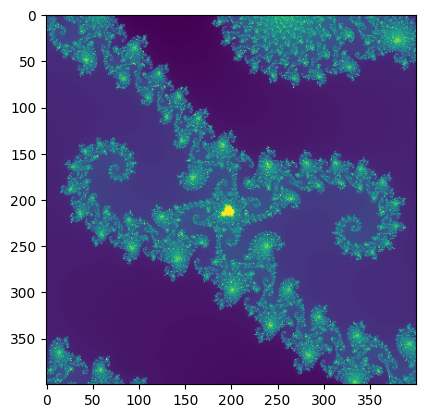

In [4]:

'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116
xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
nmax = 1000

xarr, yarr = meshgrid(xarr, yarr)

mandel = mandelbrot(xarr, yarr, nmax)
mandel

plt.imshow(np.log(mandel.T[::-1]))

In [5]:
## Autoencoder
import torch
from torch import nn
from utils import *

class Encoder(nn.Module):
    def __init__(self, n=64, h=512):
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(2)
        self.actv = nn.ELU(0.1)
        
        self.conv0 = nn.Conv2d(1, n, 3, padding=1)
        
        self.conv1 = nn.Conv2d(n, n, 3, padding=1)
        self.conv2 = nn.Conv2d(n, 2*n, 3, padding=1)
        
        self.conv3 = nn.Conv2d(2*n, 2*n, 3, padding=1)
        self.conv4 = nn.Conv2d(2*n, 3*n, 3, padding=1)
        
        self.conv5 = nn.Conv2d(3*n, 3*n, 3, padding=1)
        self.conv6 = nn.Conv2d(3*n, 3*n, 3, padding=1)
        
        self.fc = nn.Linear(16*16*3*n, h)
        
        self.cuda()
        
    def forward(self, x):
        actv = self.actv
        
        x = x.reshape(-1, 1, 64, 64)
        
        x = actv(self.conv0(x))
        
        x = actv(self.conv1(x))
        x = actv(self.conv2(x))
        self.xc2 = x
        x = self.maxpool(x)
        
        x = actv(self.conv3(x))
        x = actv(self.conv4(x))
        self.xc4 = x
        x = self.maxpool(x)
        
        x = actv(self.conv5(x))
        x = actv(self.conv6(x))
        self.xc6 = x
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        
        return x
        
        
class Decoder(nn.Module):
    def __init__(self, n=64, h=512):
        super().__init__()
        
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.actv = nn.ELU()
        
        self.fc = nn.Linear(h, 16*16*n)
        
        self.conv1 = nn.Conv2d(n, n, 3, padding=1)
        self.conv2 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv3 = nn.Conv2d(2*n, n, 3, padding=1)
        self.conv4 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv5 = nn.Conv2d(2*n, n, 3, padding=1)
        self.conv6 = nn.Conv2d(n, n, 3, padding=1)
        
        self.conv7 = nn.Conv2d(n, 1, 3, padding=1)
        
        self.cuda()
        
    def forward(self, x):
        
        actv = self.actv
        
        h0 = actv(self.fc(x))
        h0 = h0.reshape(x.size(0), -1, 16, 16)
        
        x = h0
        x = actv(self.conv1(x))
        x = actv(self.conv2(x))
        x = self.upsample(x)
        
        h0 = self.upsample(h0)
        x = torch.cat((x, h0), 1)
        x = actv(self.conv3(x))
        x = actv(self.conv4(x))
        x = self.upsample(x)
        
        h0 = self.upsample(h0)
        x = torch.cat((x, h0), 1)
        x = actv(self.conv5(x))
        x = actv(self.conv6(x))
        
        x = self.conv7(x)
        
        x = x.reshape(-1, 64, 64)
        
        return x
        
class Autoencoder(nn.Module):
    def __init__(self, n=64):
        super().__init__()
        self.enc = Encoder(n)
        self.dec = Decoder(n)
    def forward(self, x, eps=0.):
        eps = x + eps*torch.rand_like(x)
        return self.dec(self.enc(x))
    

net = Autoencoder()
net.iters = 0
net.optim = torch.optim.Adam(lr=0.001, betas=(0.9, 0.999), params=net.parameters())

In [6]:
def preprocess(imgs):
    t = imgs
    t = (t - t.mean((1,2), keepdims=True)) / (t.std((1,2), keepdims=True)+1e-2)
    t = t.clip(-5, 5)
    return t ######################
    t = t.clip(-3, 3)
    t = t.clip(-1, 1)
    #m = np.median(t, axis=(1,2), keepdims=True)
    #t = m > t
    return t
    


def _cost(imgs):
    if len(imgs)==0: return []
    t = preprocess(imgs)
    t = np2t(t)
    p = net(t)
    c = t2np(l1l2(p,t)).mean((1,2))
    return c

def cost(imgs):
    if len(imgs) > bnum:
        return np.concatenate([ _cost(imgs[bnum*i:bnum*(i+1)]) for i in range(int(len(imgs)//bnum)+1) ])
    else:
        return _cost(imgs)
    
    
    
    
bnum = 64

def trainstep(indf=None):
    if type(indf) is type(None):
        indf = lambda: np.random.randint(len(replaybuffer), size=bnum)
    net.iters += 1
    net.zero_grad()
    #t = replaybuffer[indf()]
    t = np.asarray([replaybuffer[i] for i in indf()])
    t = preprocess(t)
    t = np2t(augment8(t))
    p = net(t, eps=2)

    loss = l1l2(p,t).mean()
    loss.backward()
    net.optim.step()
    
    
    return loss.item()


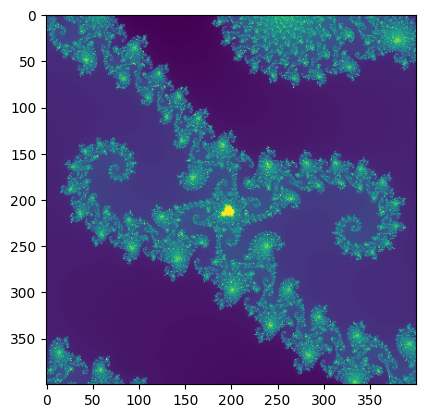

In [7]:
###
'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116
xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
nmax = 1000

xarr, yarr = meshgrid(xarr, yarr)

mandel = mandelbrot(xarr, yarr, nmax)

im = np.log(mandel.T[::-1])
im = preprocess(im[None])[0]

plt.imshow(im)

In [8]:

import torch
from torch import nn
from utils import *
actv = nn.functional.relu
actv = nn.functional.gelu

from torch.nn.functional import interpolate

class EDSR(nn.Module):
    def __init__(self, channels=64, inter=5): ####### war 15
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, 5, padding=2, padding_mode='reflect')
        # EDSR Variant
        self.convblocks1 = nn.ModuleList([nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)])
        self.convblocks2 = nn.ModuleList([nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)])
        #self.convblocks1 = nn.ModuleList([nn.Conv2d(channels, channels//3*2, 3, padding=1, padding_mode='reflect') for k in range(inter)]) # GLU 1x
        #self.convblocks2 = nn.ModuleList([nn.Conv2d(channels//3*1, channels, 3, padding=1, padding_mode='reflect') for k in range(inter)]) # GLU 1x
        
        self.conv_post = nn.Conv2d(channels, channels, 3, padding=1, padding_mode='reflect')
        self.upconv1 = nn.Conv2d(channels, 4*channels, 3, padding=1, padding_mode='reflect')
        self.upconv2 = nn.Conv2d(channels, 4*channels, 3, padding=1, padding_mode='reflect')
        self.convlast = nn.Conv2d(channels, 1, 9, padding=4, padding_mode='reflect')
        
        self.cuda()
        self.epoch = 0
        self.iters = 0
        self.trainloss = []
        self.valloss = []
        
    @staticmethod
    def pixelshuffle(x, f=2):
        'Pixel shuffle im Format NCHW'
        n, c, h, w = x.shape
        x = x.view(n, c//f**2, f, f, h, w)
        x = x.permute(0, 1, 4, 2, 5, 3)
        #x = x.permute(0, 1, 2, 4, 3, 5)
        x = x.reshape(n, c//f**2, f*h, f*w)
        return x
            
    def forward(self, x):
        # NHWC zu NCHW
        x = x.permute([0, 3, 1, 2])
        x_bilin = interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)
        x -= 0.5
        x_res = x = actv(self.conv1(x))
        
        for conv1, conv2 in zip(self.convblocks1, self.convblocks2):
            x = x + 0.1 * conv2(actv(conv1(x)))
            #x = x + 0.1 * conv2(glu(conv1(x)))
        x = x_res + self.conv_post(x)
        
        x = self.pixelshuffle(self.upconv1(x))
       ## x = self.pixelshuffle(self.upconv2(x))
        
        x = self.convlast(x)
        #x = self.convlast(x) + 0.5
        x = doubleleaky(x, alpha=0.1)
        
        # restore NHWC-Format
        x = x.permute([0, 2, 3, 1])
        return x
    
    def eval(self, x, mbs=2):
        batches = [ x[mbs*i:mbs*(i+1)] for i in range(len(x)//mbs)]
        return torch.cat([self(b) for b in batches])
    
net = EDSR()
net.iters = 0
net.optim = torch.optim.Adam(lr=0.001, betas=(0.9, 0.999), params=net.parameters())

In [9]:


def _cost(hr):
    if len(hr)==0: return []
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    c = abs(sr-hr).mean((1,2,3))
    return t2np(c)

def cost(imgs):
    if len(imgs) > bnum:
        return np.concatenate([ _cost(imgs[bnum*i:bnum*(i+1)]) for i in range(int(len(imgs)//bnum)+1) ])
    else:
        return _cost(imgs)

In [10]:
bnum = 64

def trainstep(indf=None):
    if type(indf) is type(None):
        indf = lambda: np.random.randint(len(replaybuffer), size=bnum)
    net.iters += 1
    
    net.zero_grad()
    hr = np.asarray([replaybuffer[i] for i in indf()])
    hr = (hr - hr.mean((1,2), keepdims=True)) / (hr.std((1,2), keepdims=True)+1e-2)
    hr = hr.clip(-3, 3)
    hr = hr[:,:,:,None]
    hr = np2t(hr)
    lr = hr[:,::2,::2]  # downscale by next neighbour
    sr = net(lr)
    loss = abs(sr-hr).mean()

    loss.backward()
    net.optim.step()
    
    return loss.item()

In [11]:
preprocess(im[None]).shape

(1, 400, 400)

  0%|          | 0/100 [00:00<?, ?it/s]

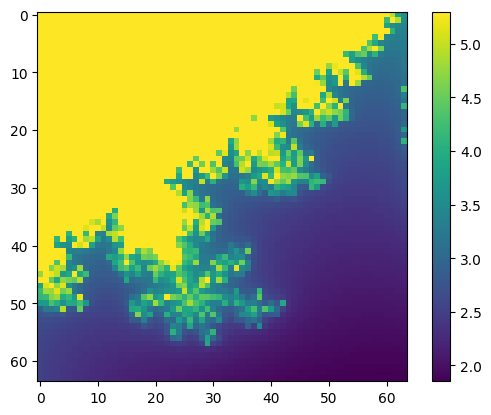

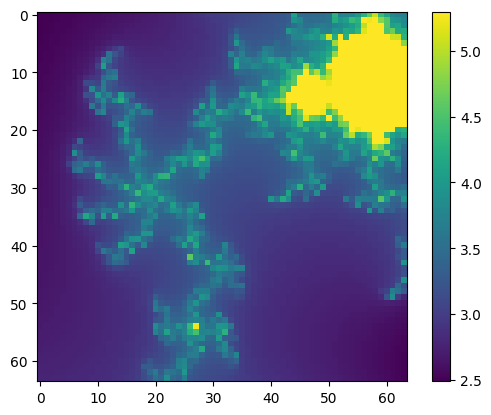

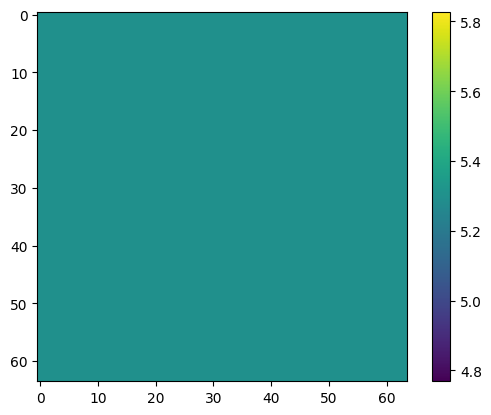

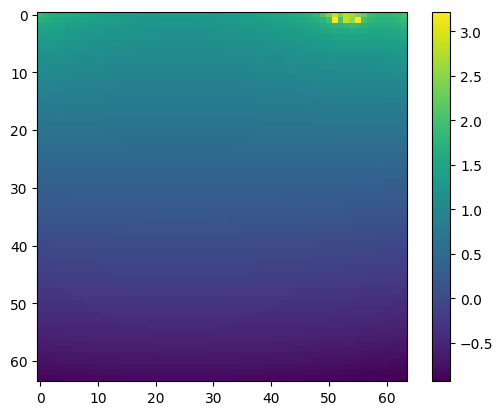

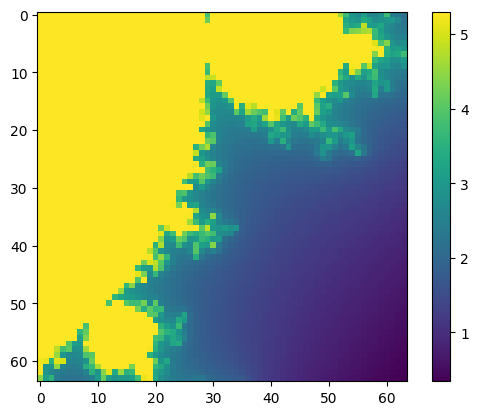

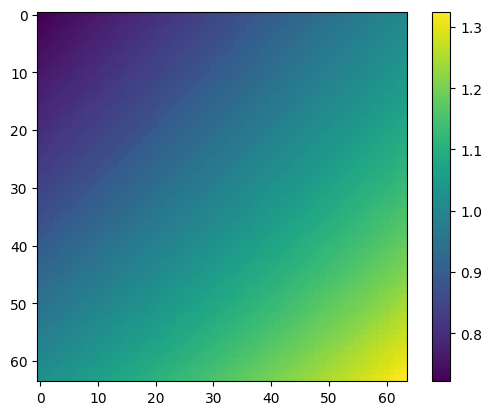

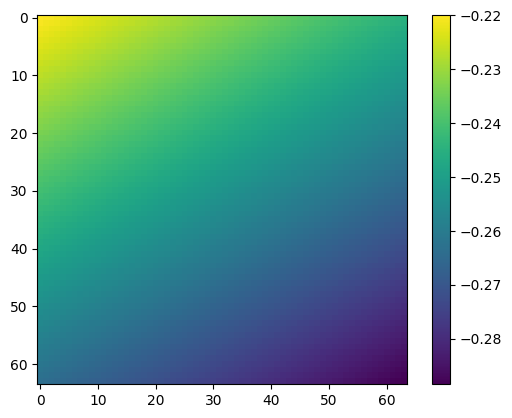

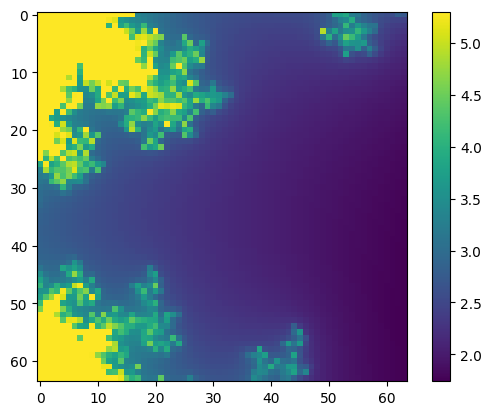

C:\Users\Ma Ha\AppData\Local\Temp\ipykernel_16936\605747487.py:14: RuntimeWarning: invalid value encountered in log
  mandel = np.log(mandel)


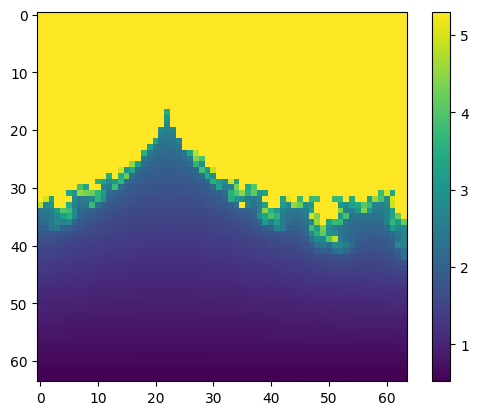

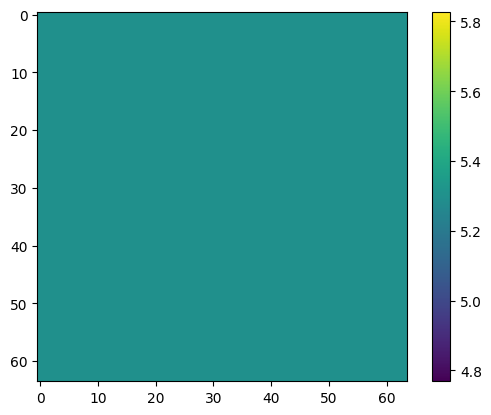

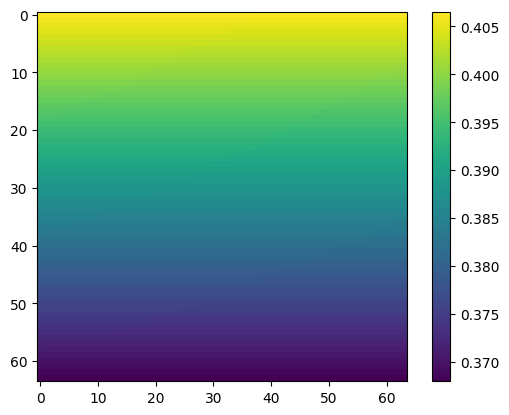

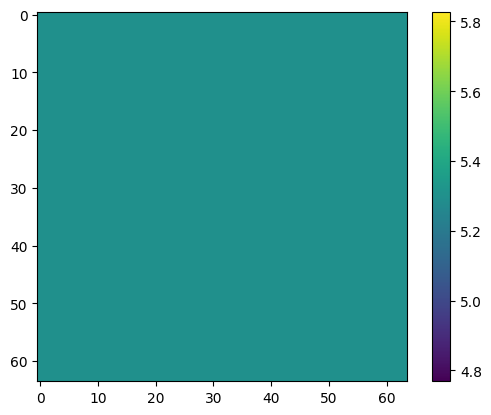

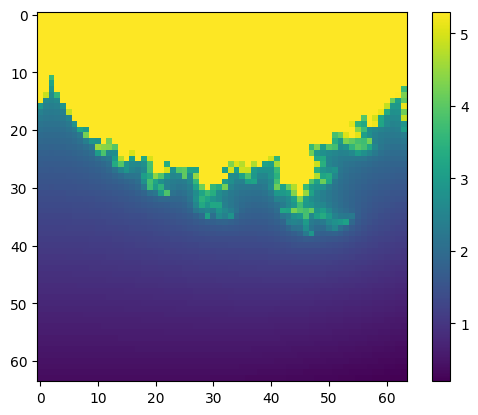

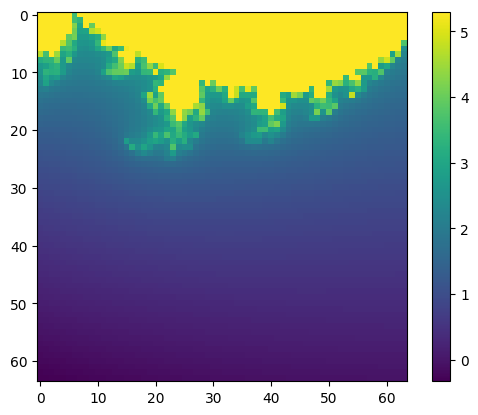

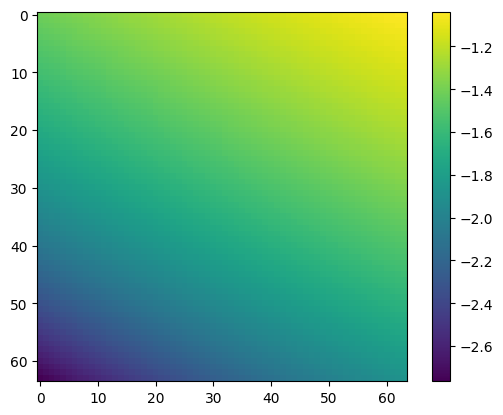

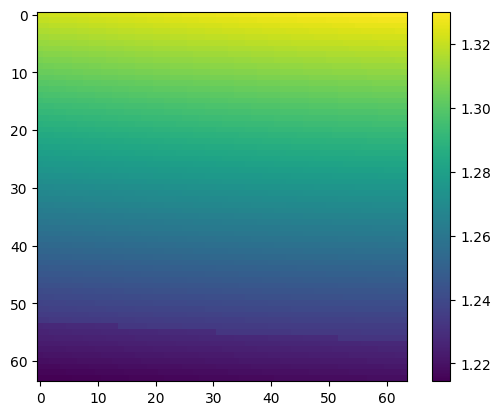

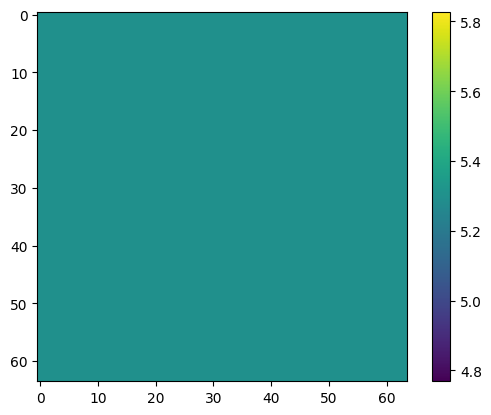

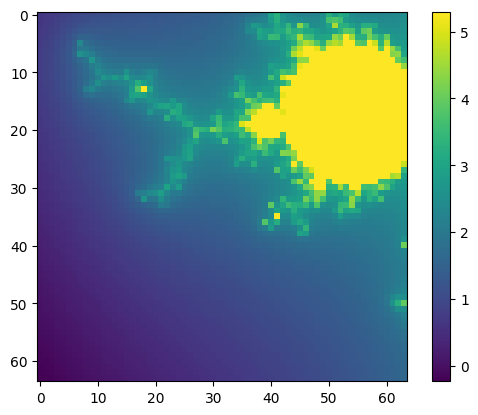

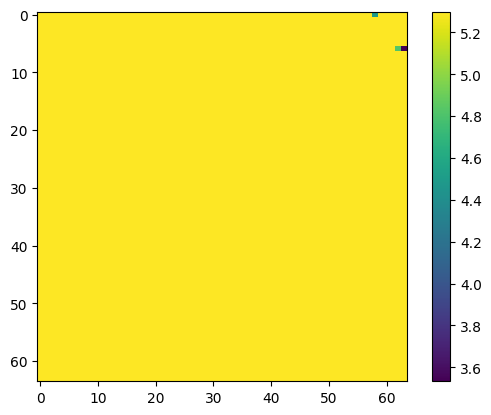

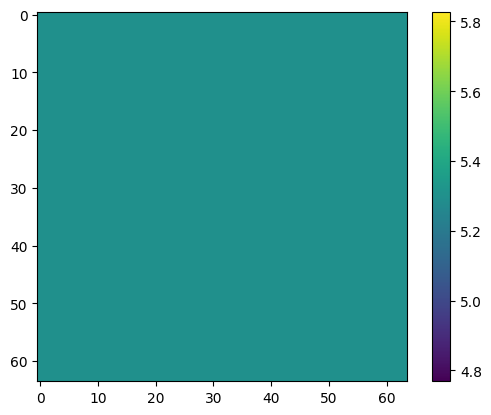

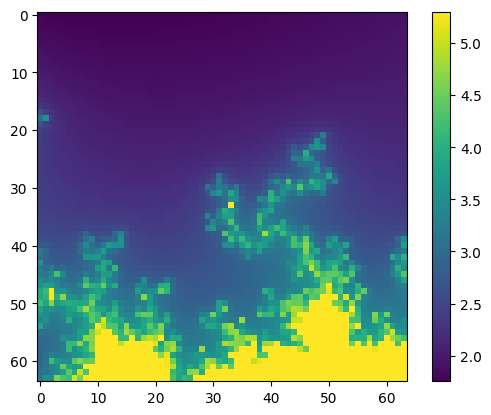

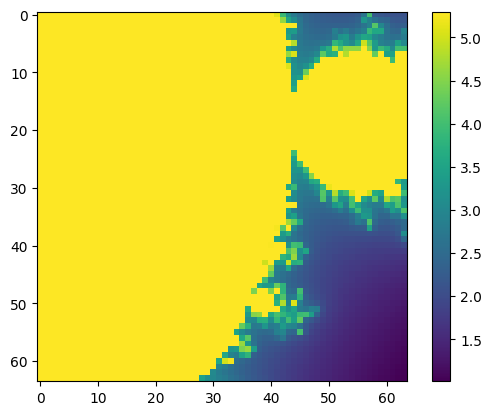

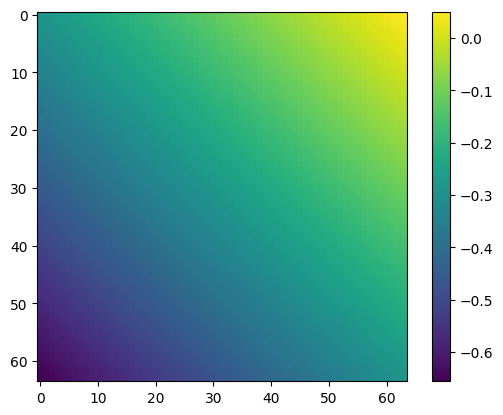

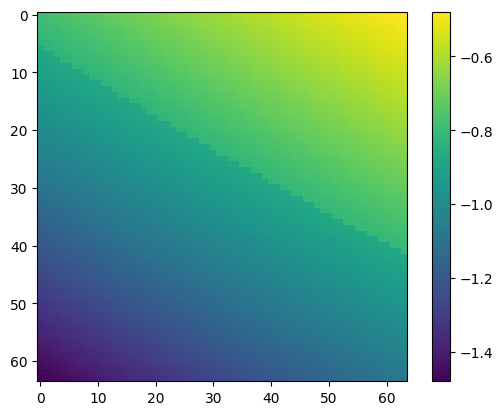

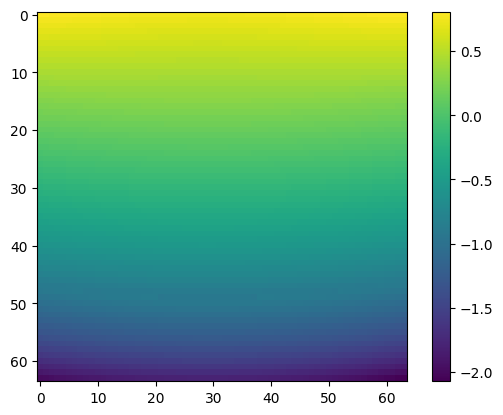

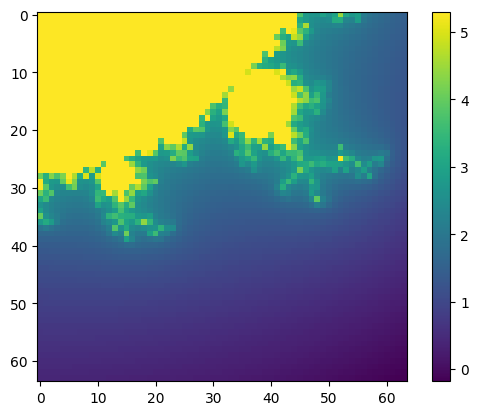

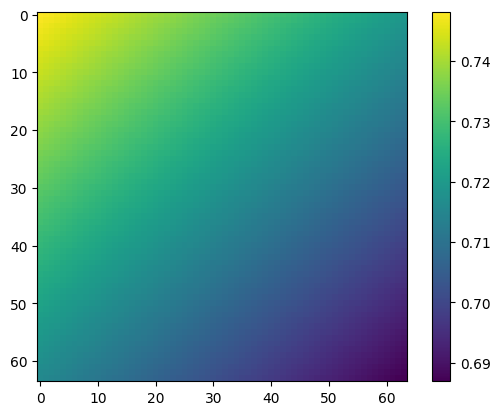

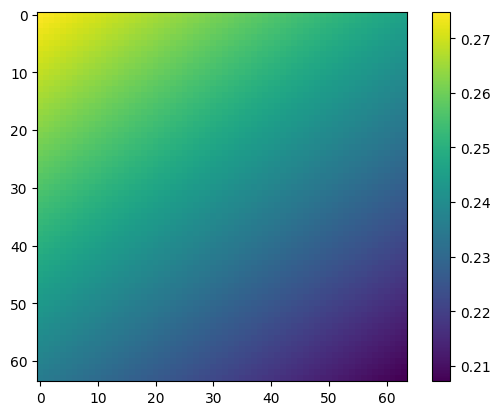

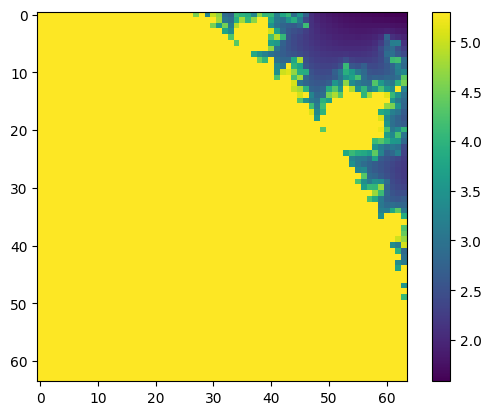

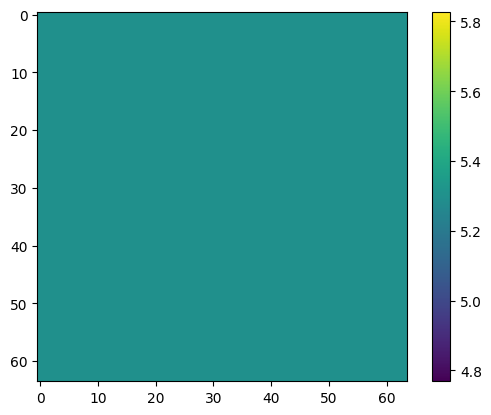

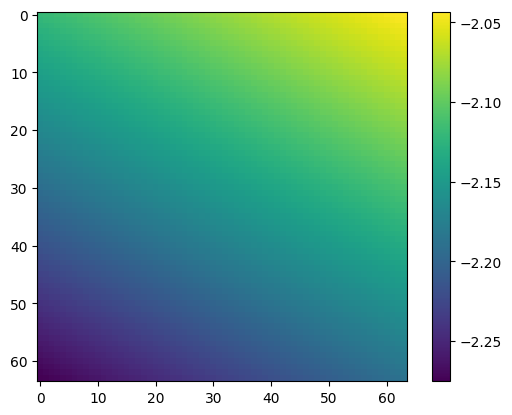

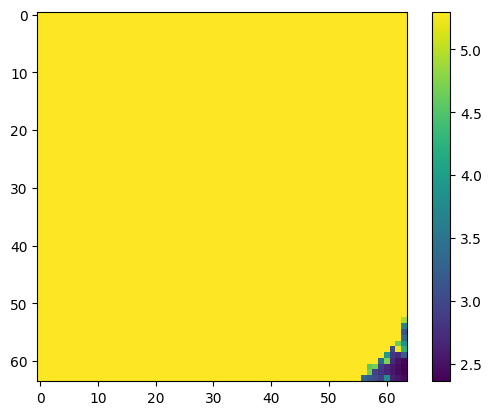

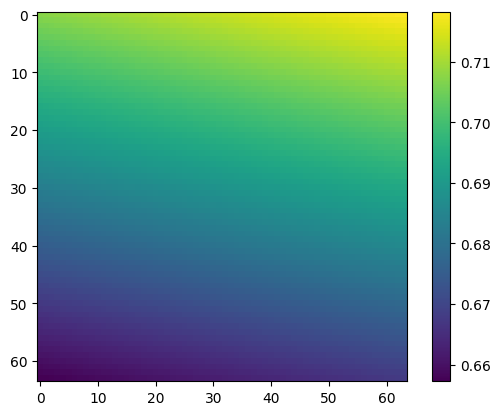

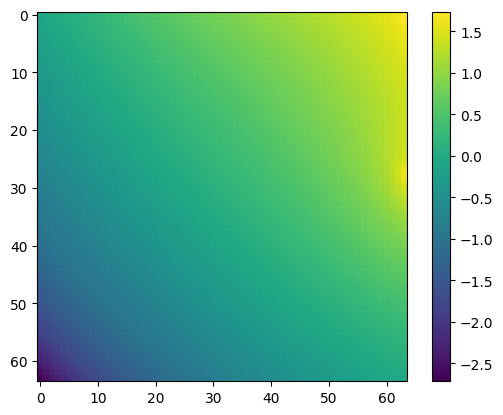

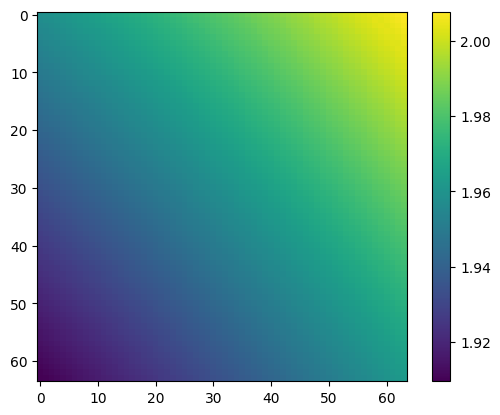

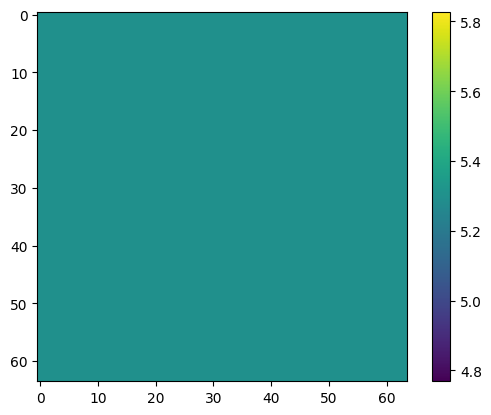

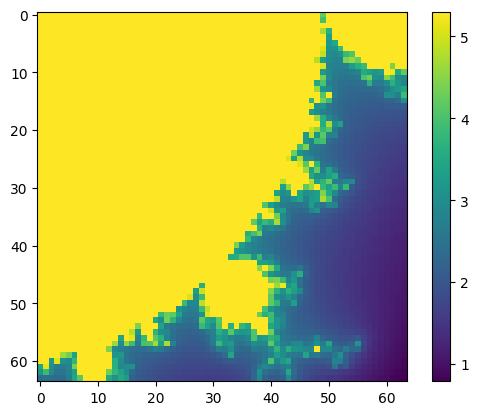

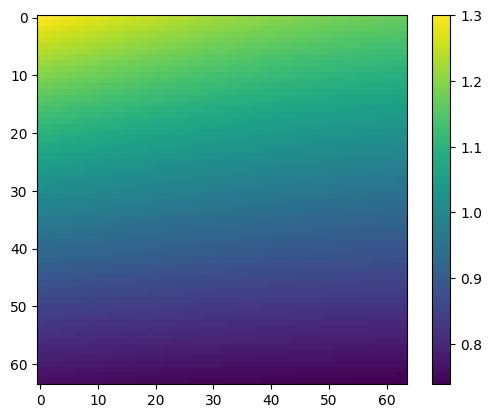

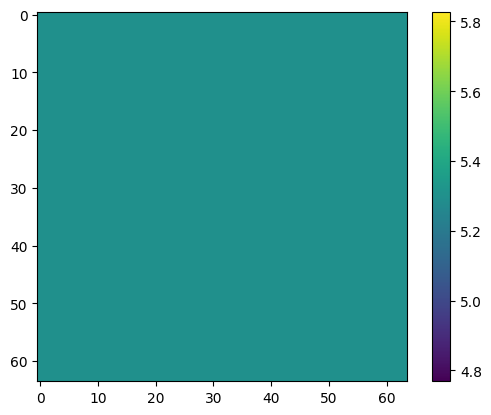

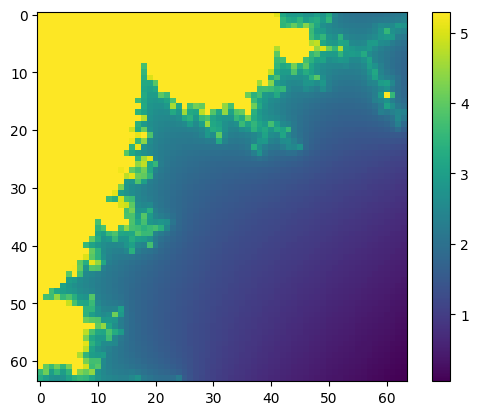

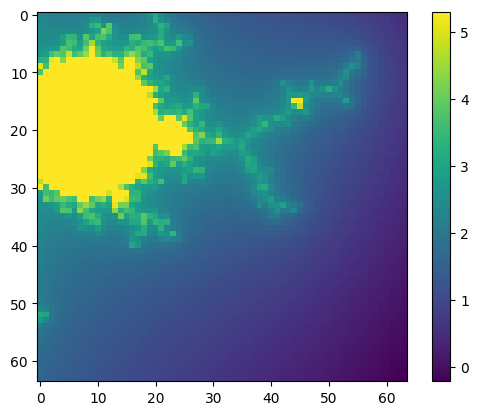

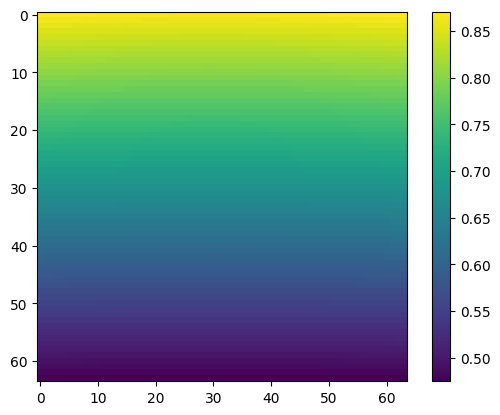

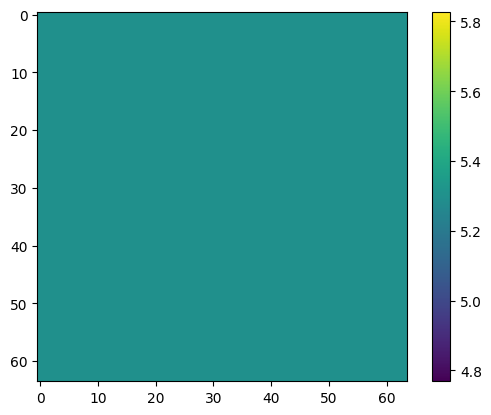

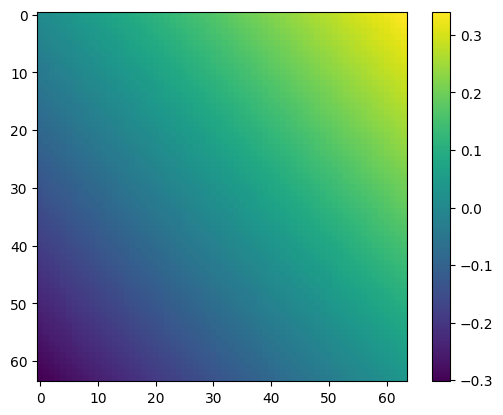

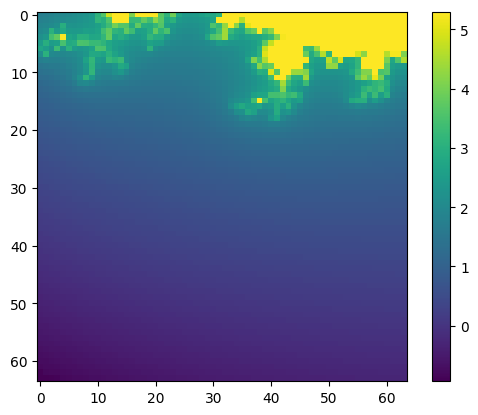

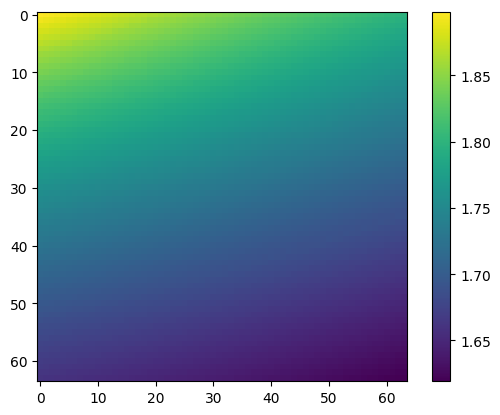

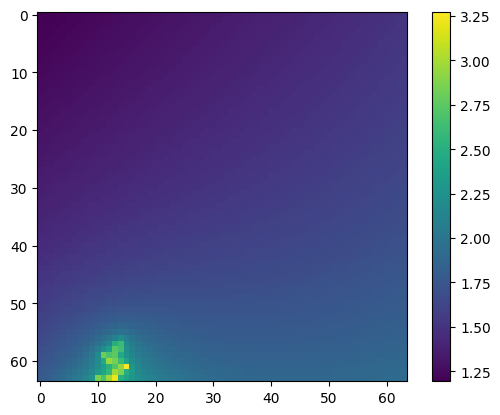

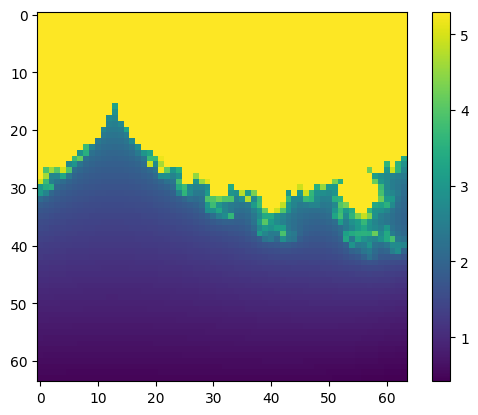

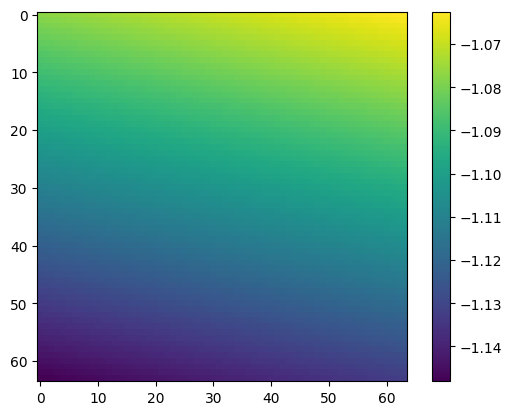

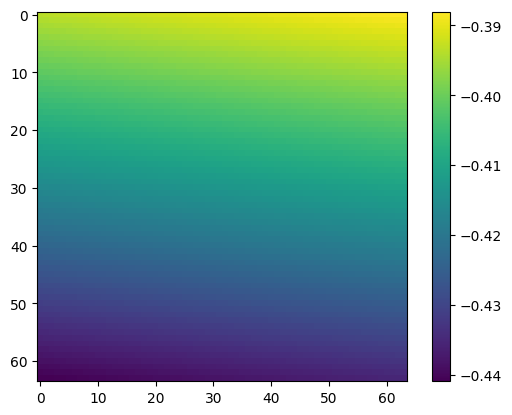

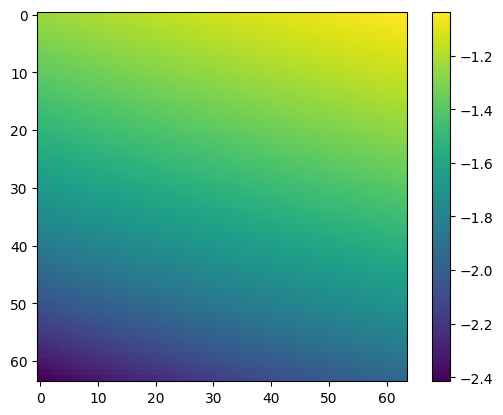

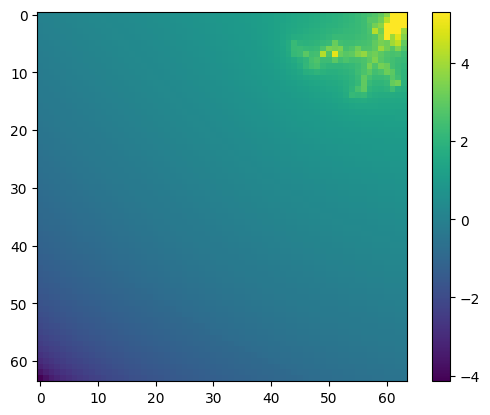

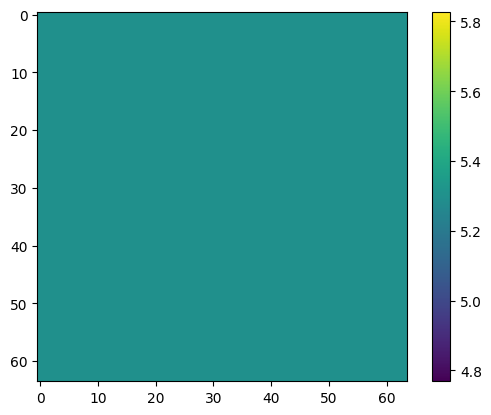

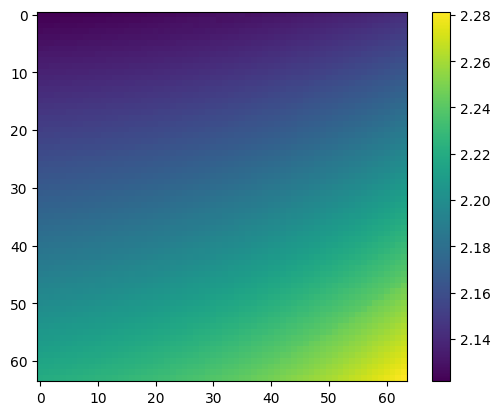

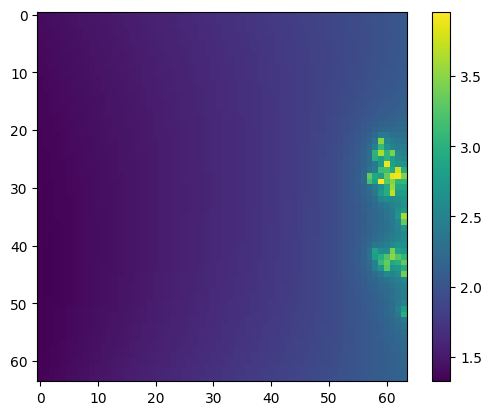

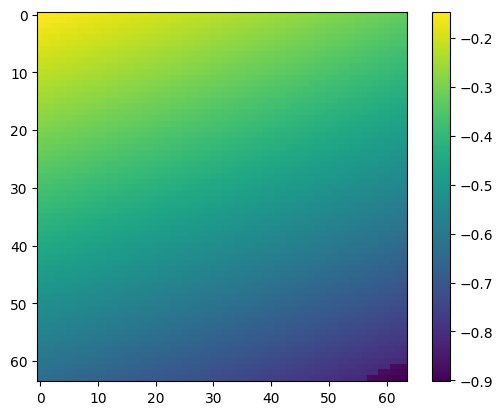

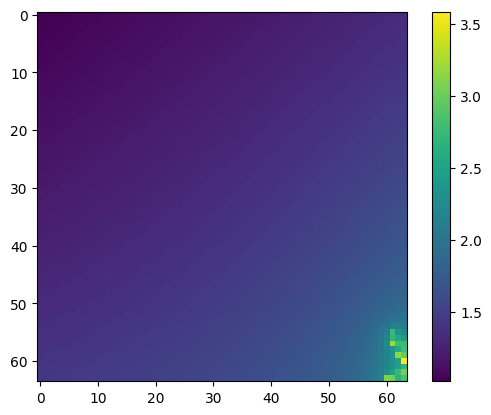

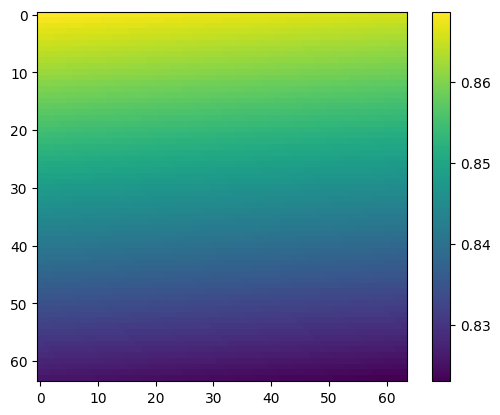

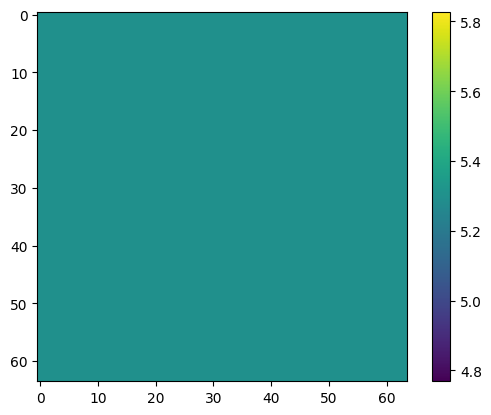

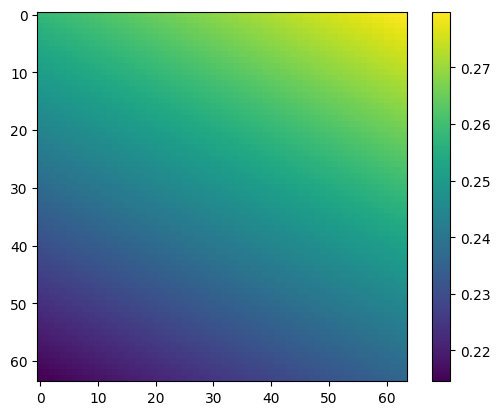

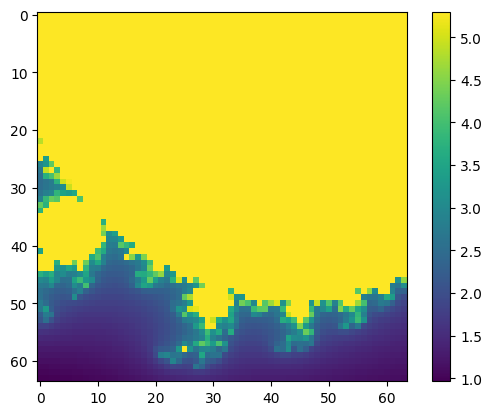

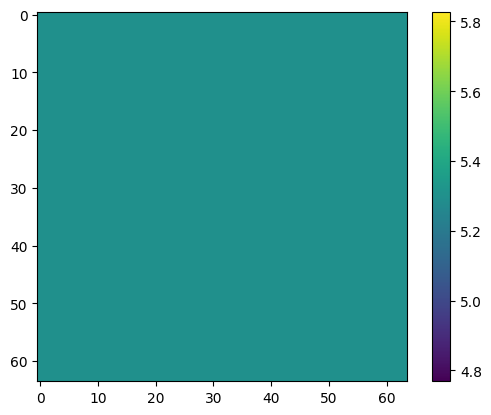

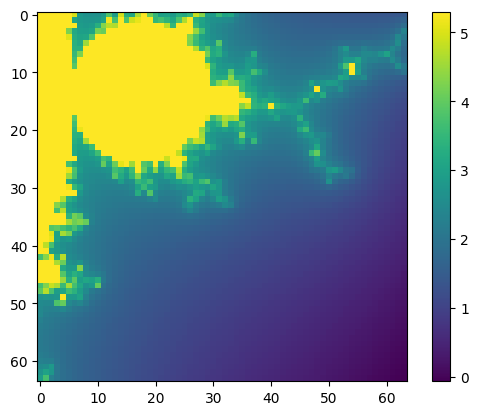

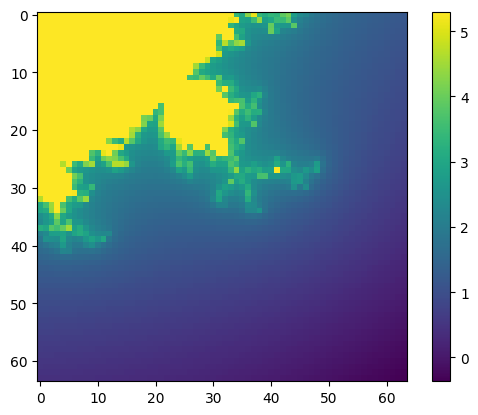

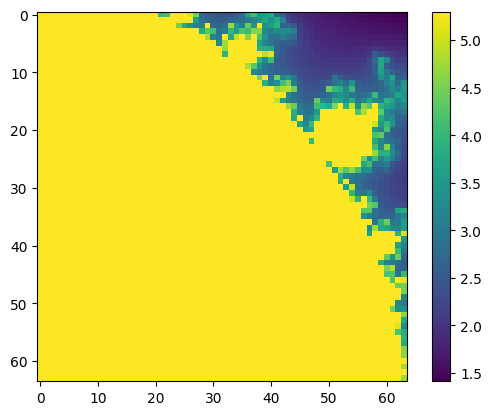

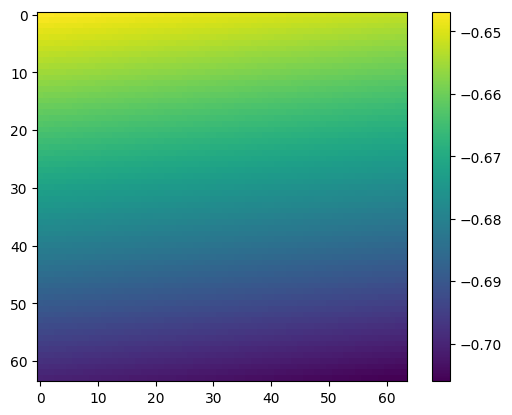

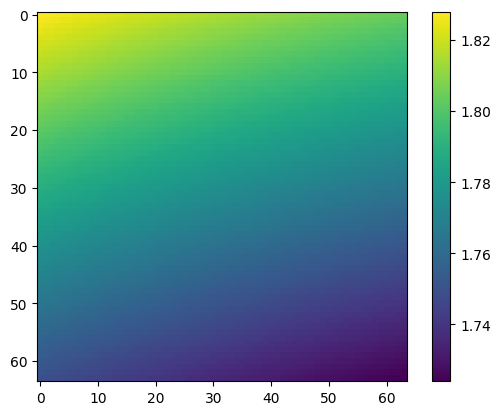

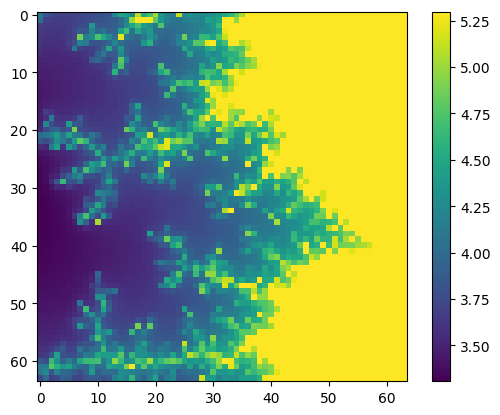

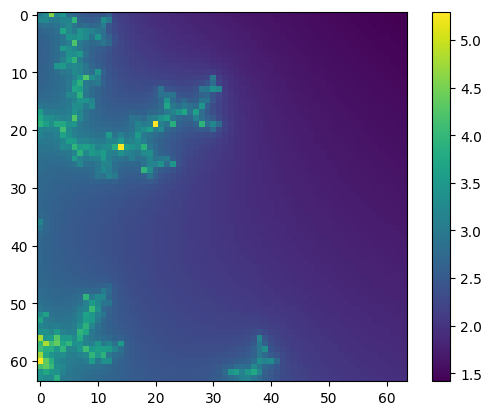

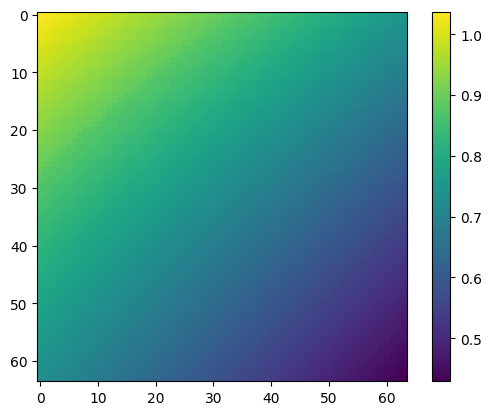

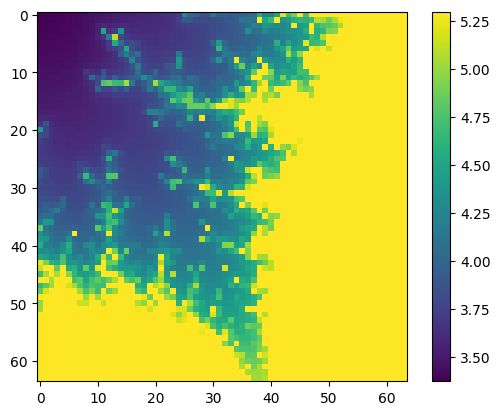

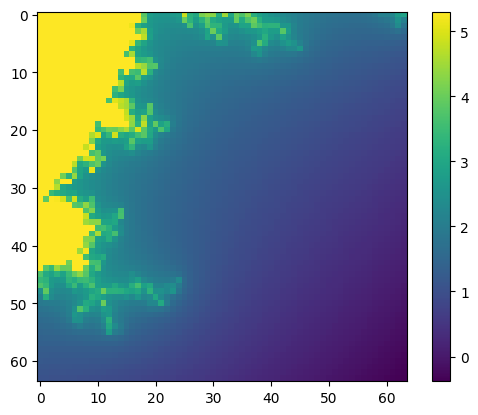

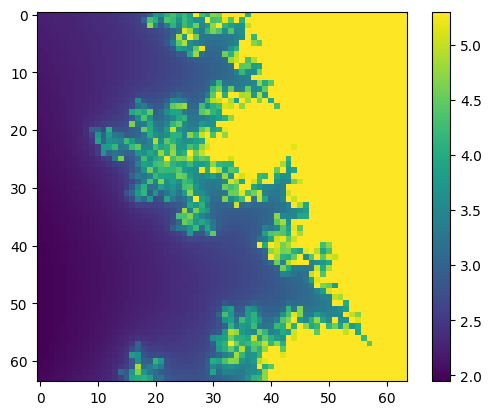

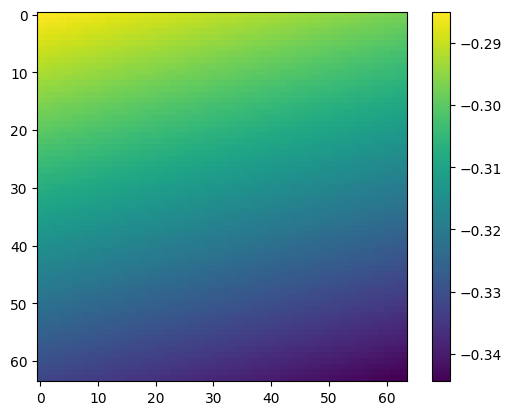

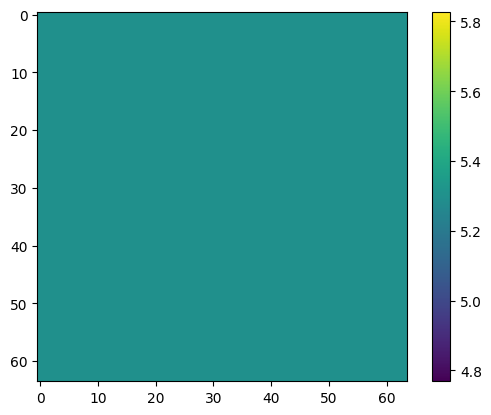

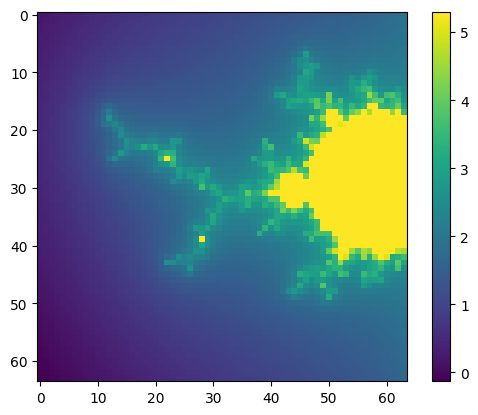

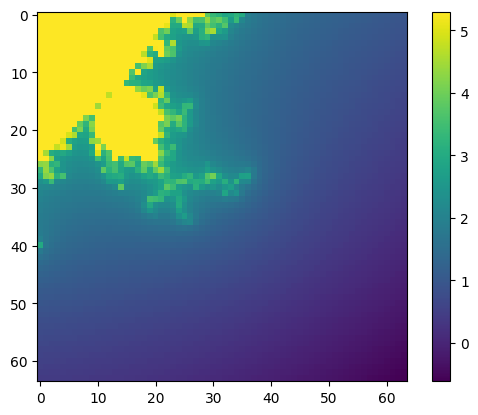

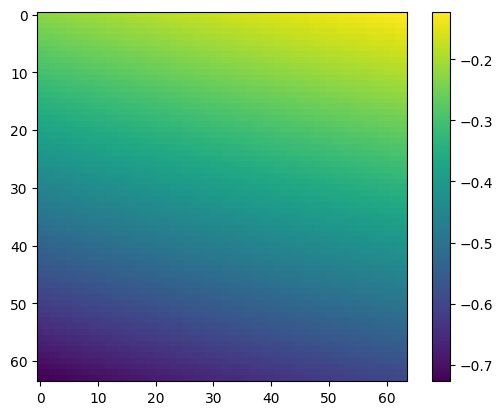

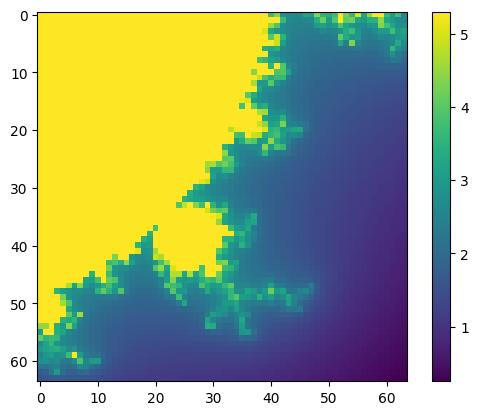

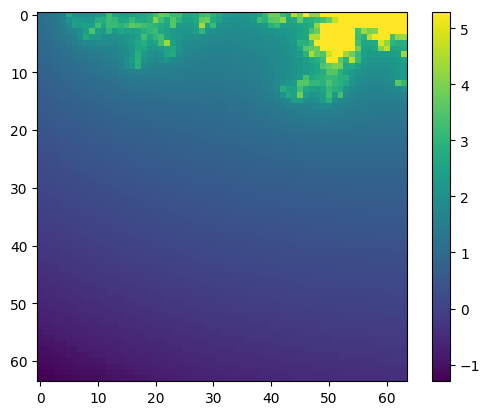

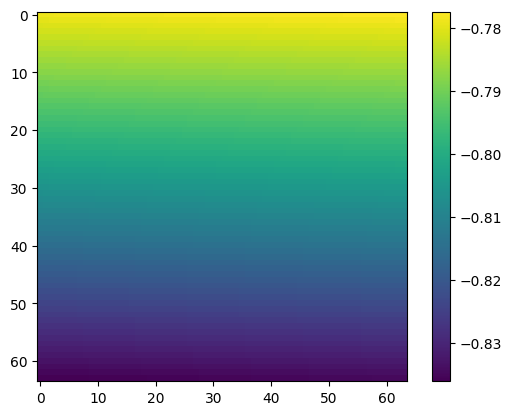

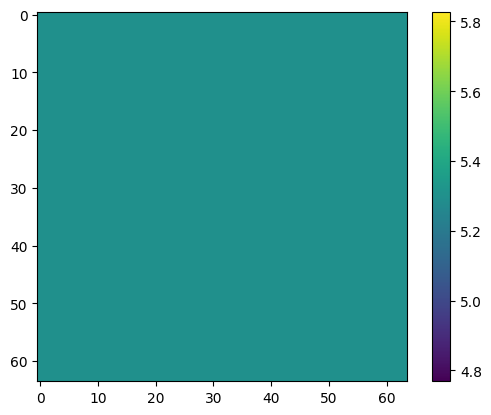

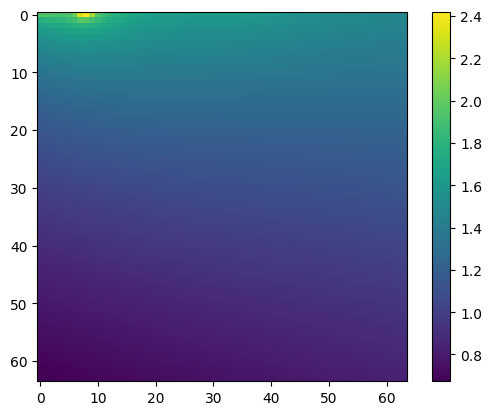

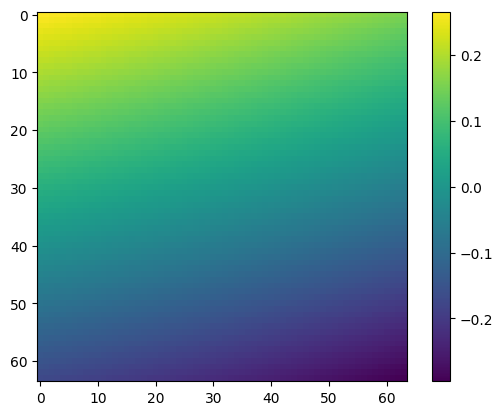

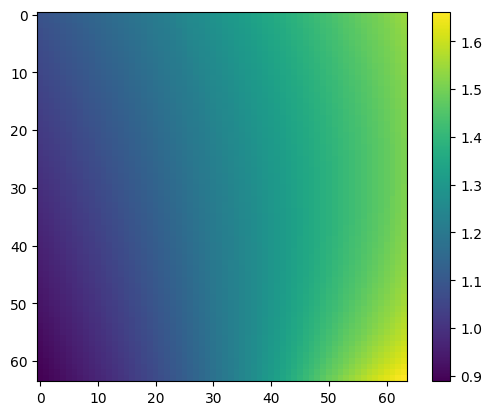

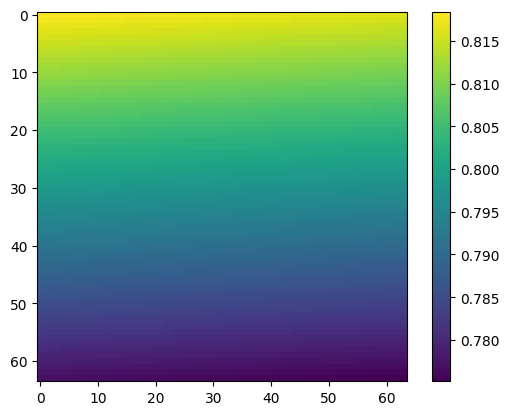

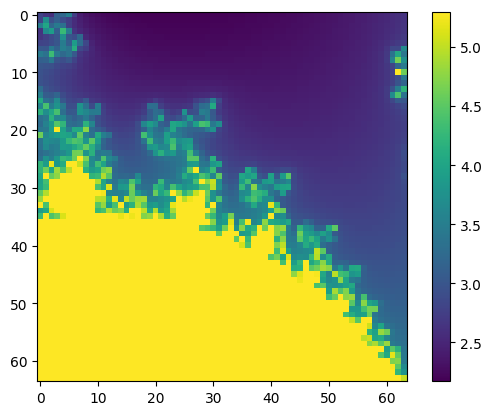

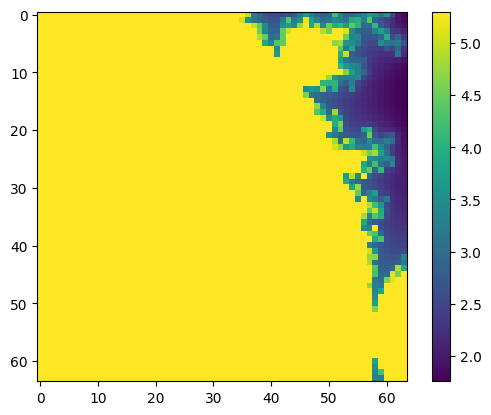

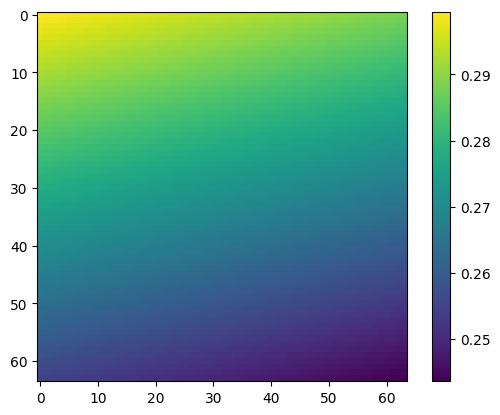

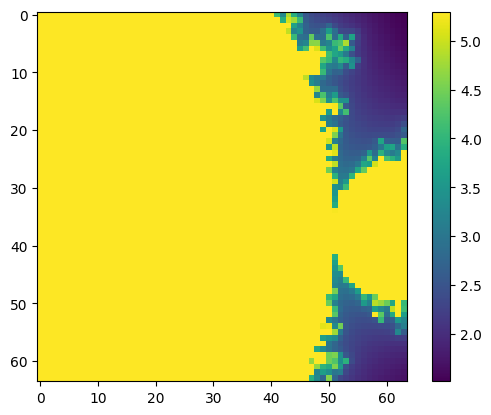

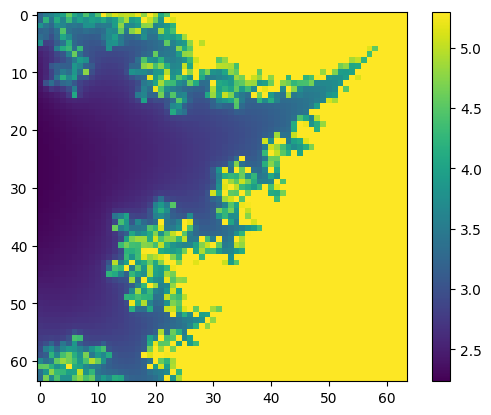

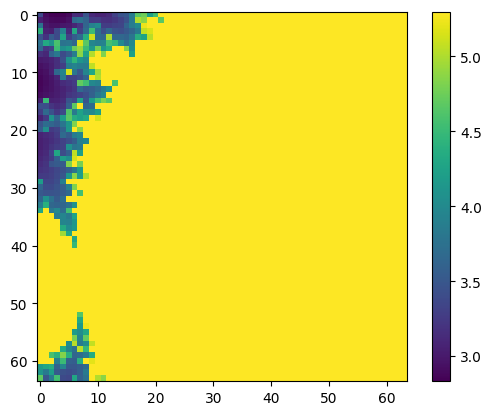

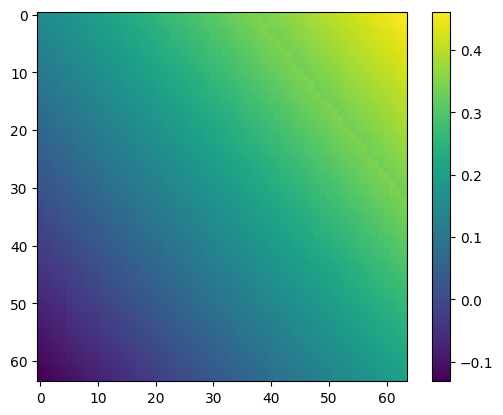

In [12]:
# Einige Bilder in den replaybuffer packen und schon mal das Netzwerk vortrainieren

replaybuffer = []
np.random.seed(0)
for _ in trange(100):
    mid = np.random.rand()*1.5-0.5, np.random.rand()*2-1
    width = np.random.choice([0.5, 0.1, 0.01])
    xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 64)
    yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 64)
    nmax = 200
    xarr, yarr = meshgrid(xarr, yarr)
    
    mandel = mandelbrot(xarr, yarr, nmax)
    mandel = np.log(mandel)
    if np.any(np.isnan(mandel)): continue
    plt.imshow(mandel)
    plt.colorbar()
    plt.show()
    replaybuffer.append(mandel)
    
#replaybuffer = np.asarray(replaybuffer)

In [13]:
for _ in trange(50):
    print(trainstep())

  0%|          | 0/50 [00:00<?, ?it/s]

0.6760127544403076
0.6049031019210815
0.4293099343776703
0.3518396317958832
0.4323004186153412
0.29311394691467285
0.296134889125824
0.3136024475097656
0.28405800461769104
0.2470134198665619
0.2247045934200287
0.2517913281917572
0.23253317177295685
0.19447767734527588
0.19181308150291443
0.205128476023674
0.18970683217048645
0.19783133268356323
0.18296898901462555
0.1788199245929718
0.17156489193439484
0.18618649244308472
0.18356189131736755
0.17920786142349243
0.17685848474502563
0.18653370440006256
0.15460342168807983
0.14673630893230438
0.17704573273658752
0.14915722608566284
0.1521509885787964
0.14266517758369446
0.12583357095718384
0.12485584616661072
0.1345992386341095
0.11012060940265656
0.11459329724311829
0.11499175429344177
0.11004924774169922
0.1066504642367363
0.15029376745224
0.16148744523525238
0.16303741931915283
0.1484021246433258
0.1509081870317459
0.14455468952655792
0.14055030047893524
0.13723865151405334
0.1441032886505127
0.1274999976158142


In [12]:
replaybuffer[i]

NameError: name 'i' is not defined

In [14]:
cs = _cost(np.asarray(replaybuffer[:]))

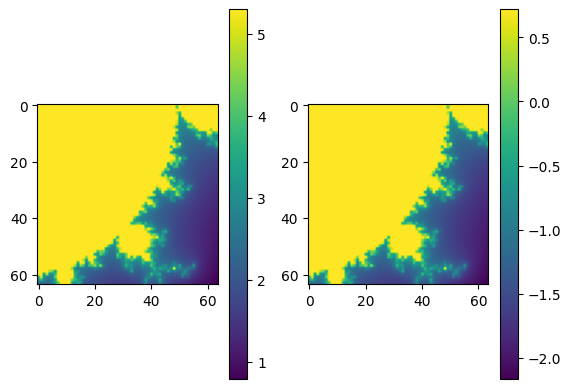

0.2795781


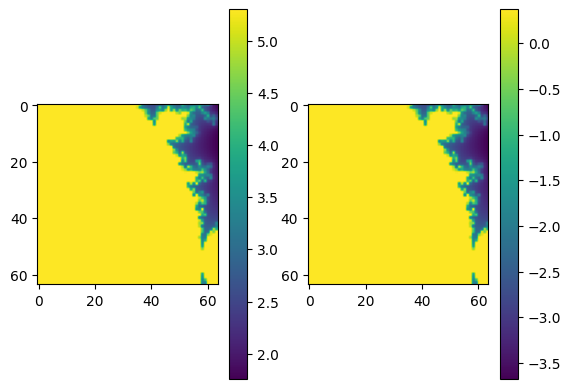

0.2778477


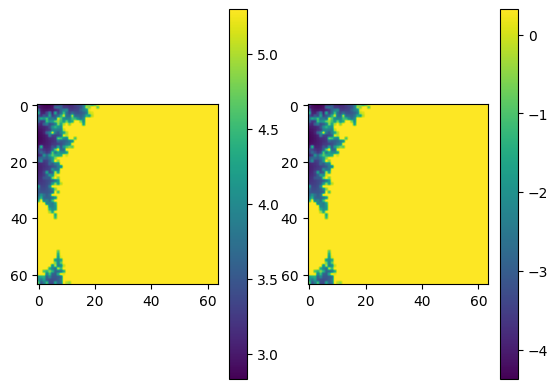

0.27704942


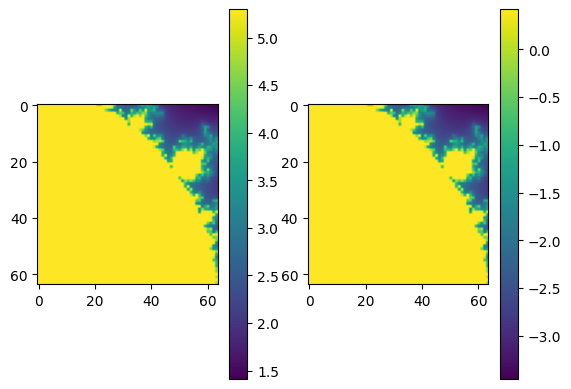

0.27182865


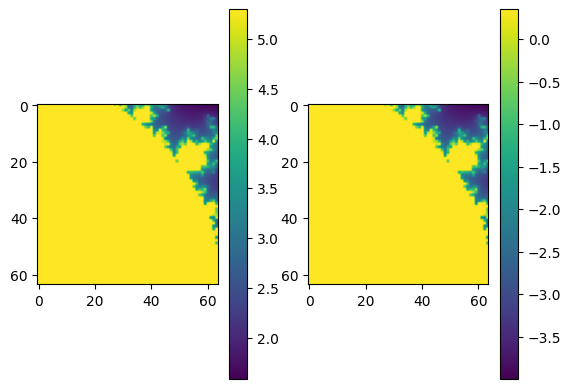

0.2683256


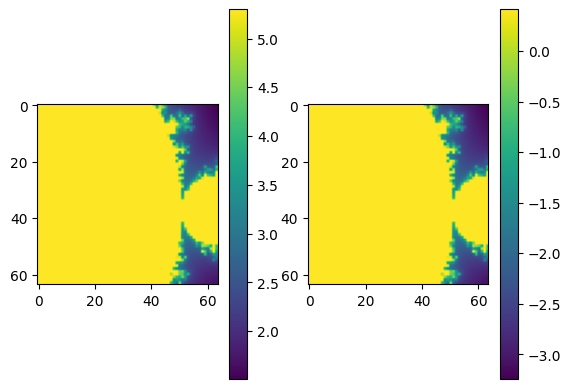

0.25806856


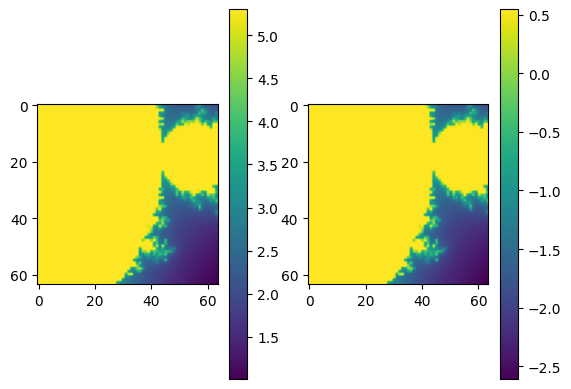

0.25060365


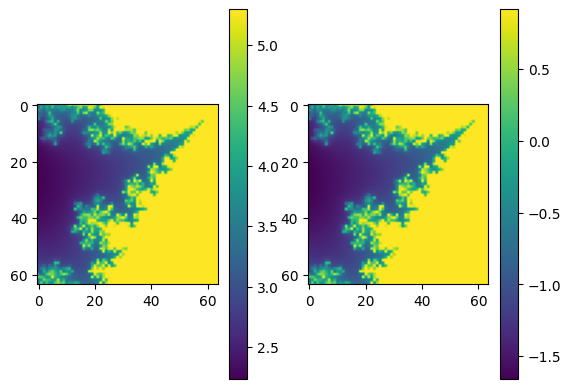

0.2419813


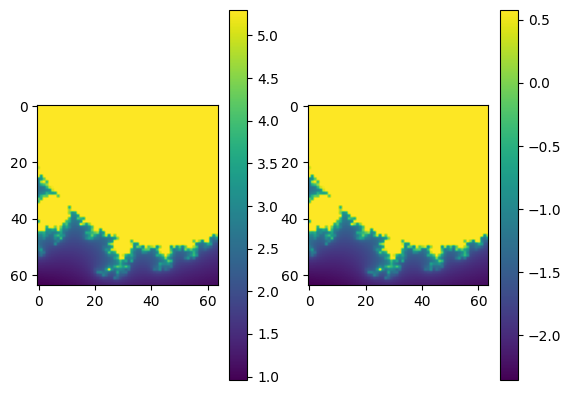

0.23781954


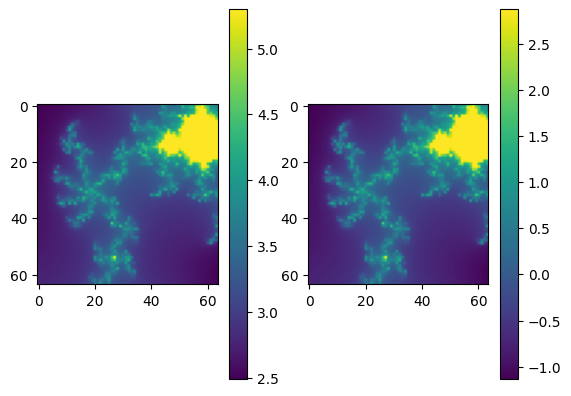

0.23471546


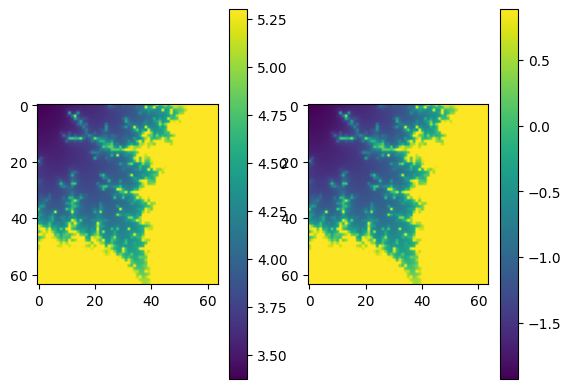

0.21979204


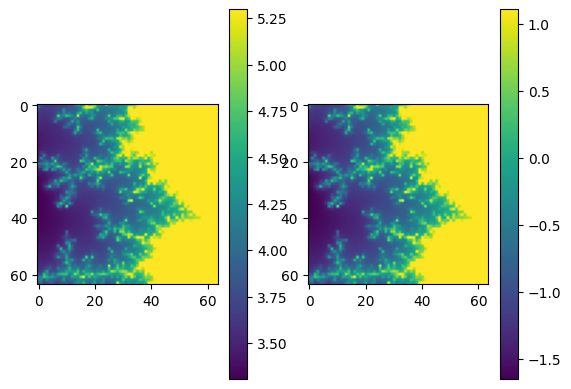

0.1963628


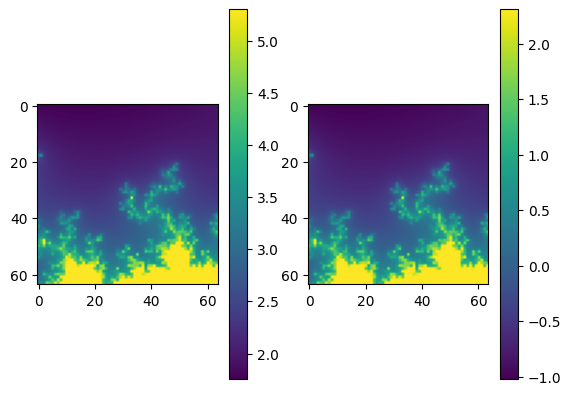

0.19561484


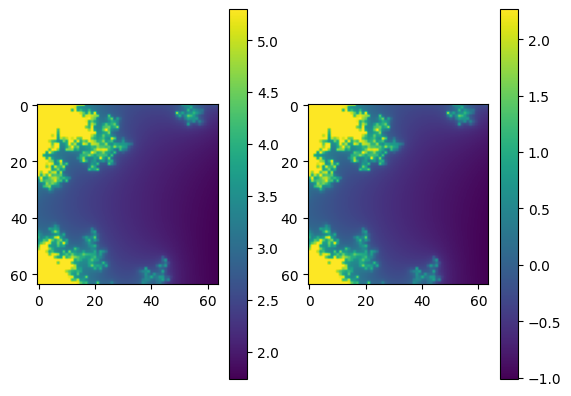

0.18587172


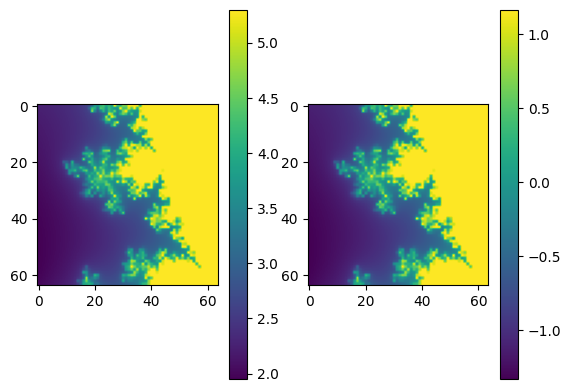

0.1738407


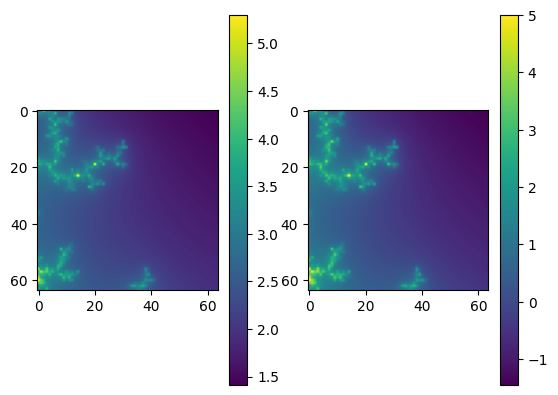

0.17164785


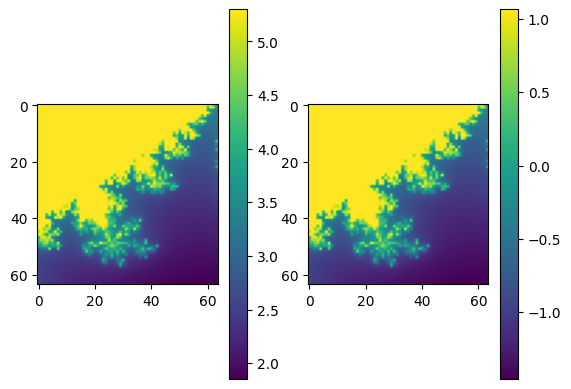

0.17076583


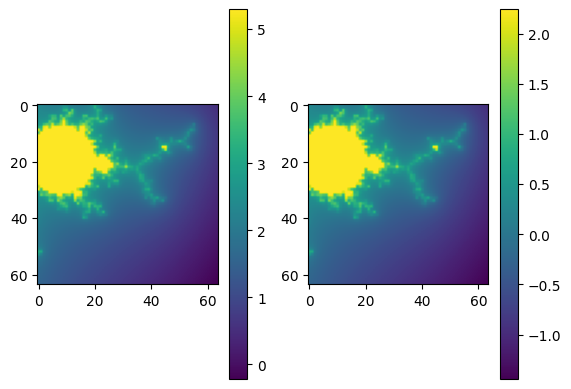

0.1604589


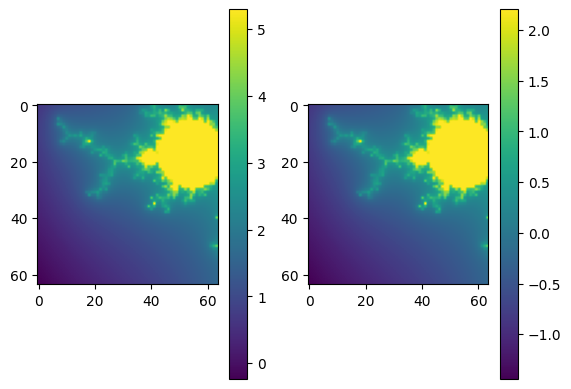

0.15909716


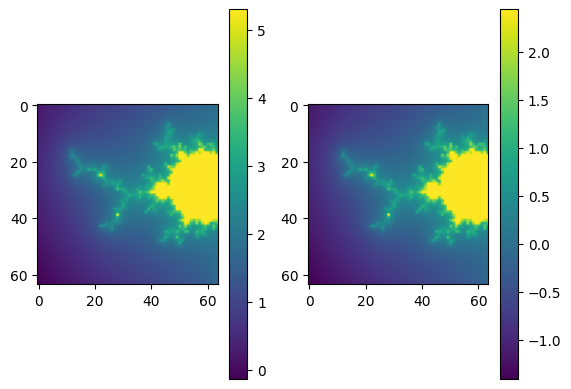

0.15713799


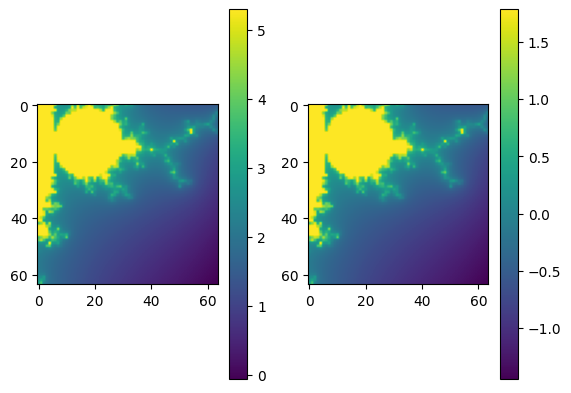

0.15397182


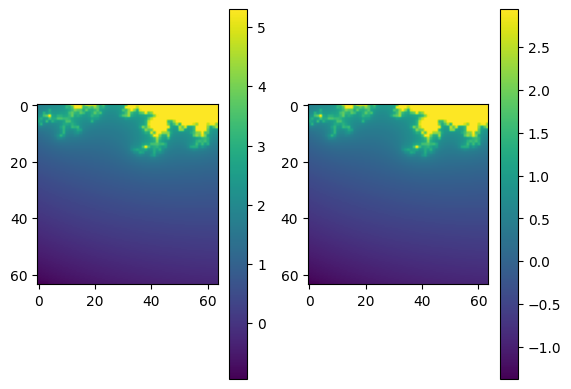

0.14970624


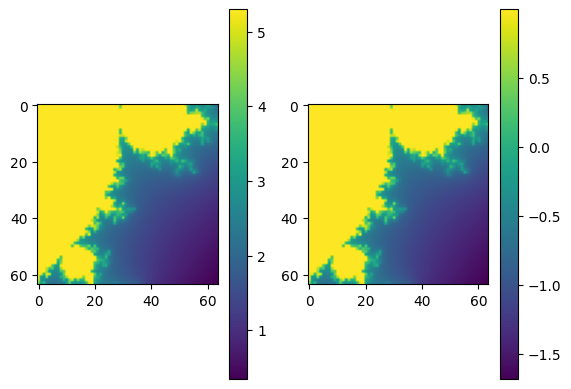

0.14823142


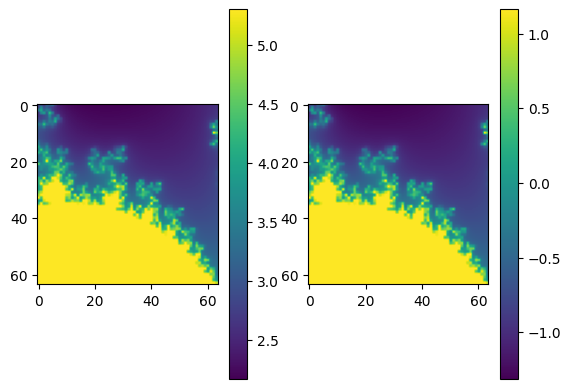

0.14801297


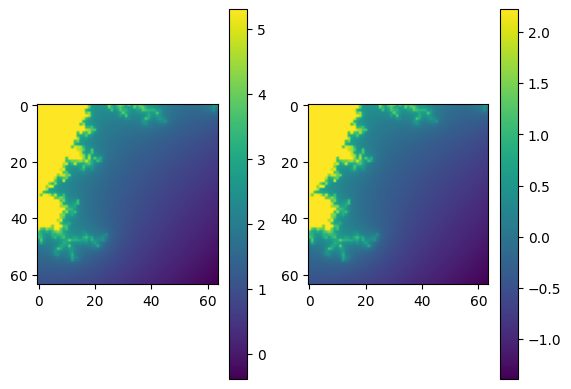

0.14587969


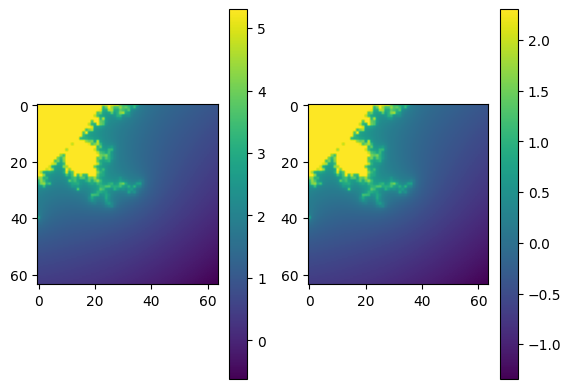

0.13508573


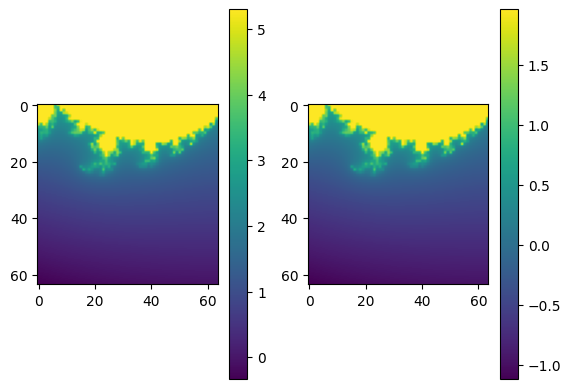

0.12745792


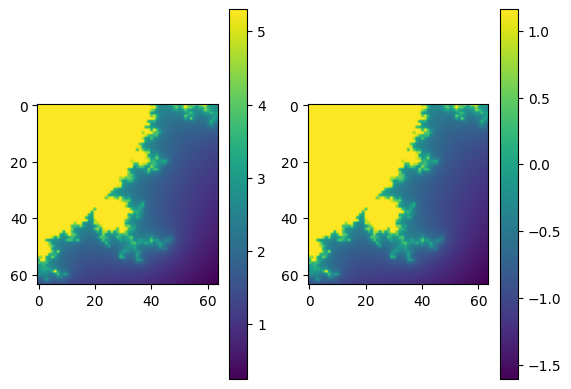

0.1271606


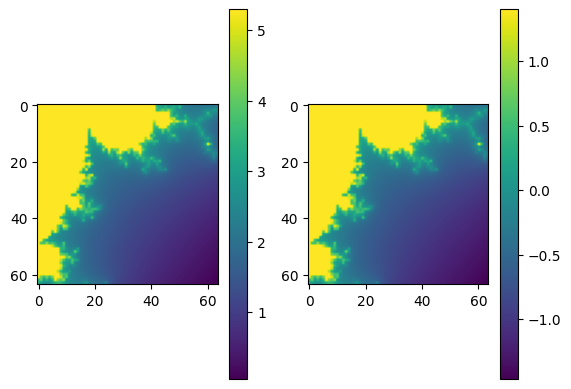

0.12660438


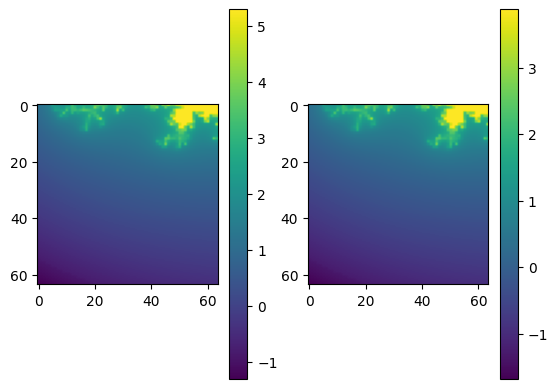

0.12196785


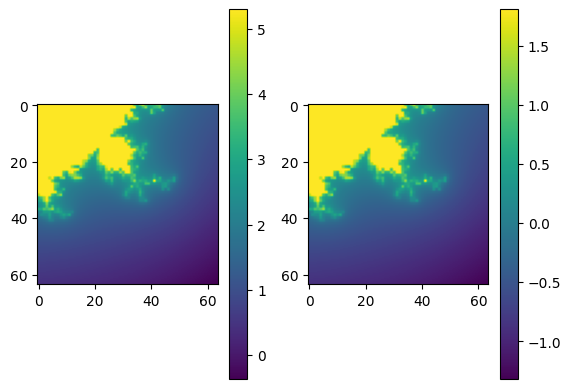

0.119574115


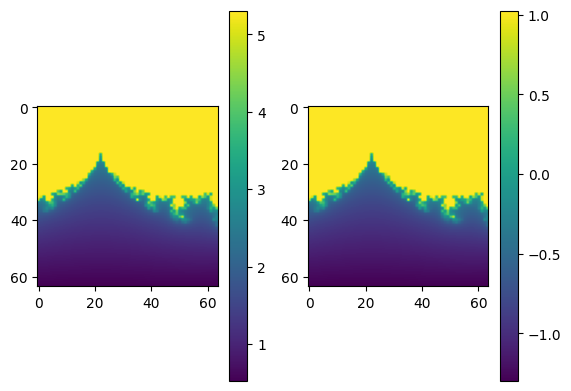

0.11494339


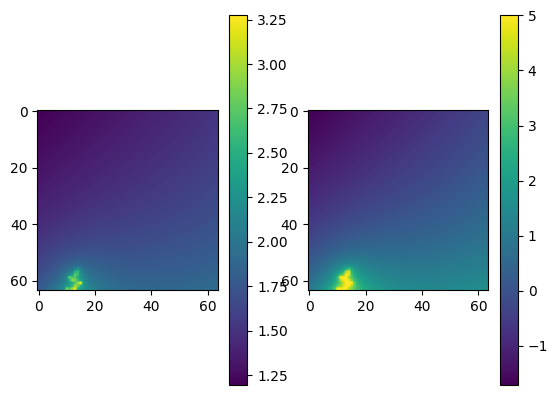

0.11255567


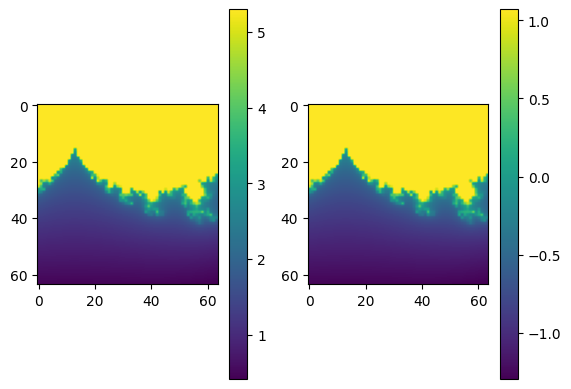

0.11016897


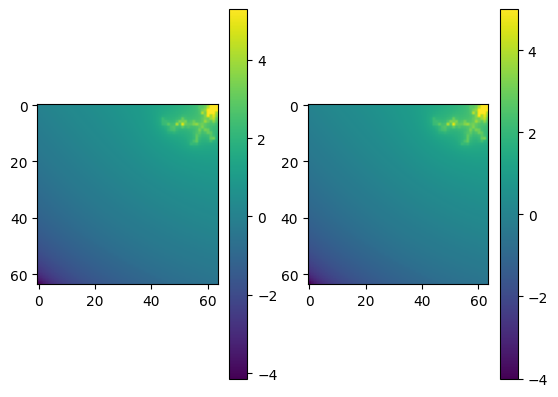

0.109436154


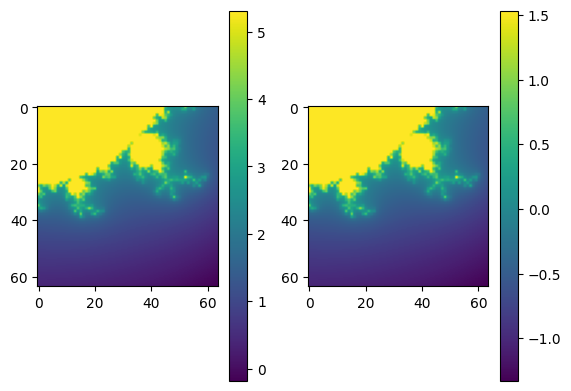

0.10916905


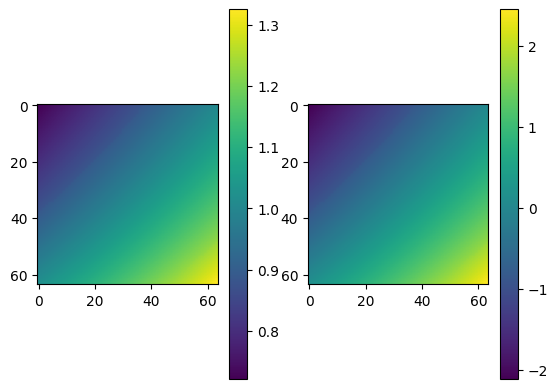

0.105951026


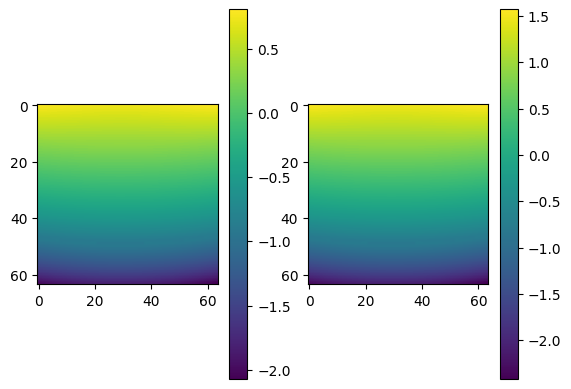

0.10532075


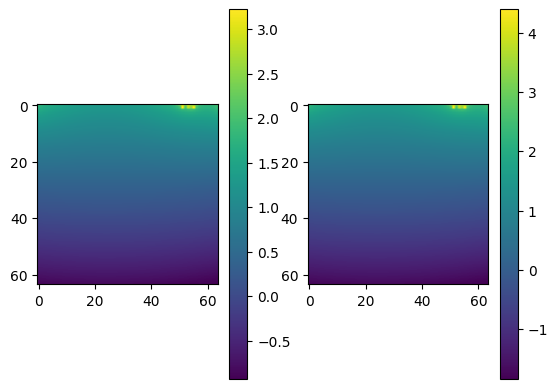

0.10484831


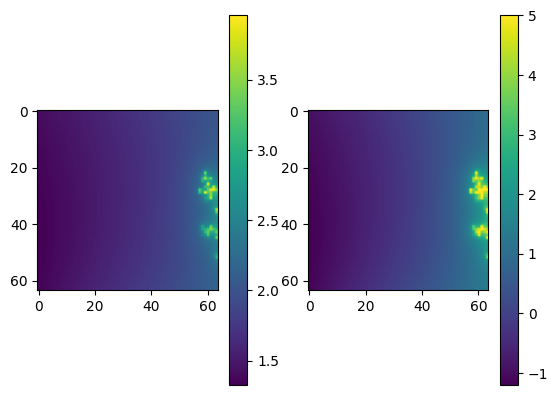

0.104545355


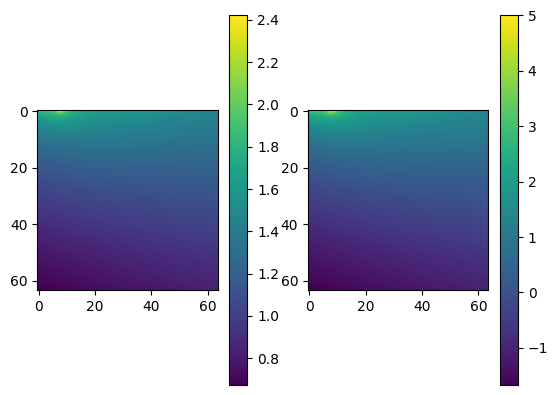

0.101737484


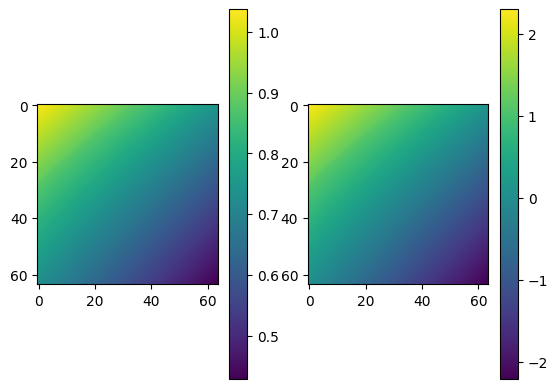

0.10159499


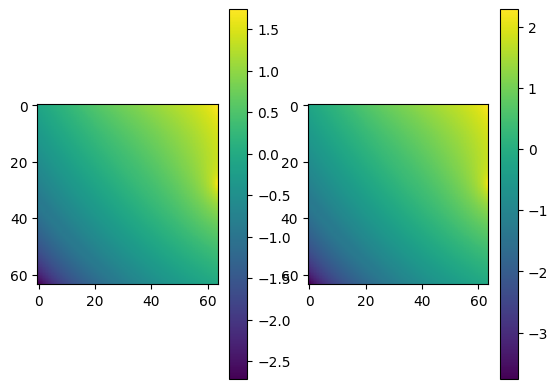

0.10098905


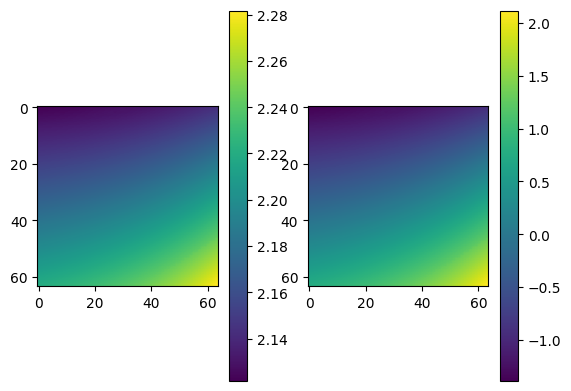

0.1006525


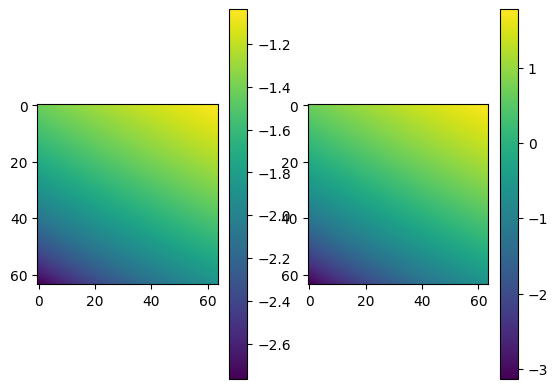

0.10023479


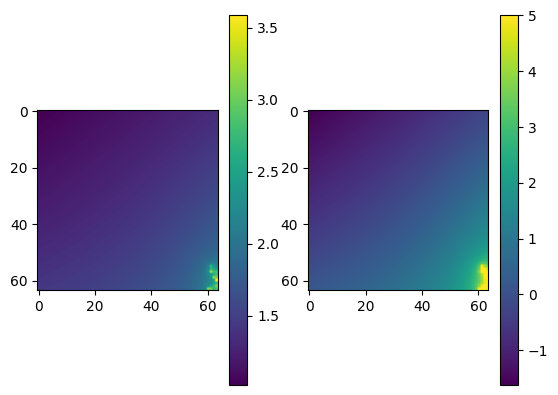

0.09991083


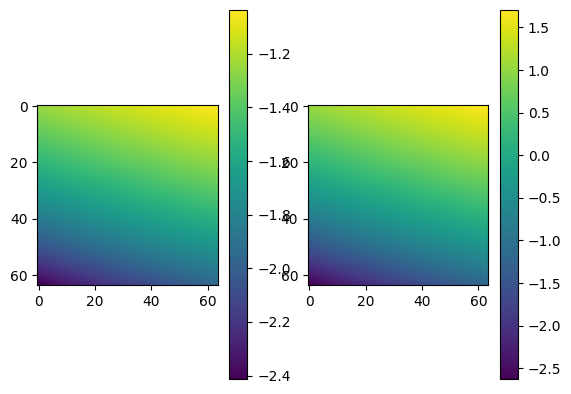

0.098437995


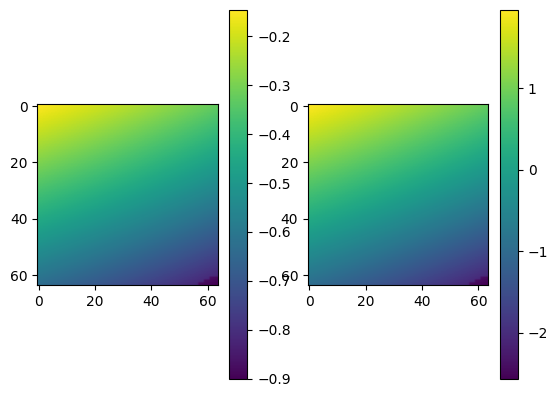

0.09759402


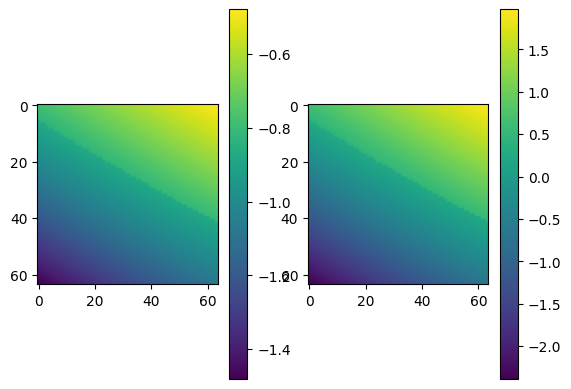

0.09628528


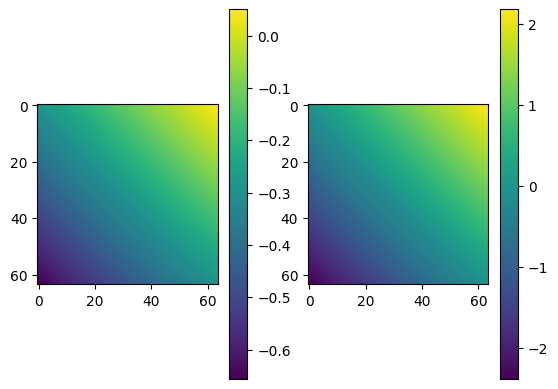

0.09488606


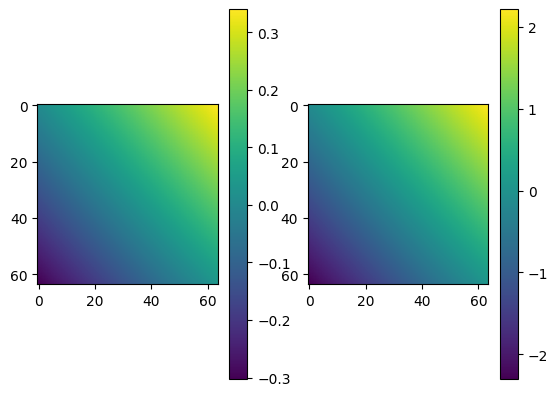

0.09410122


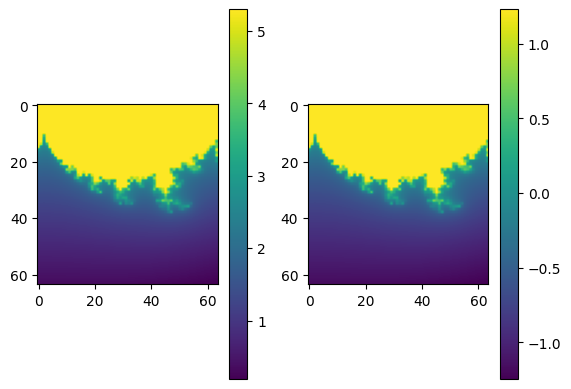

0.09404005


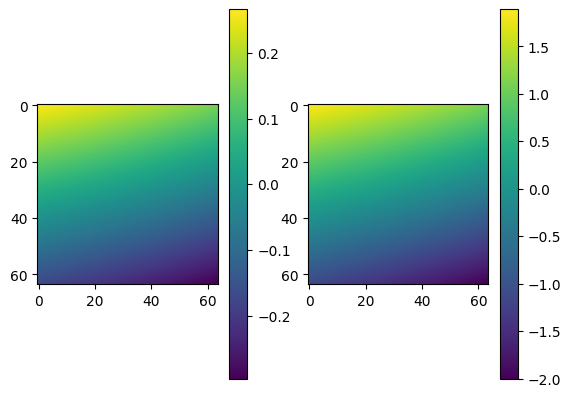

0.09372981


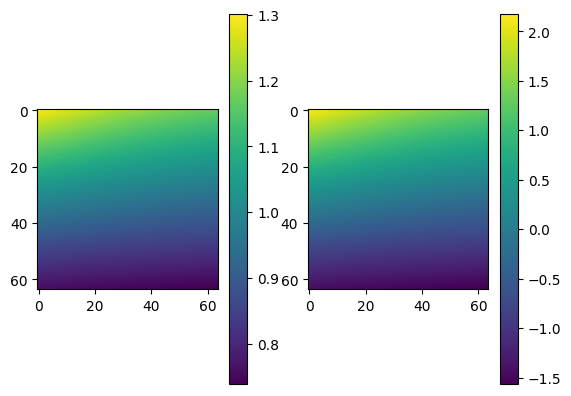

0.093605265


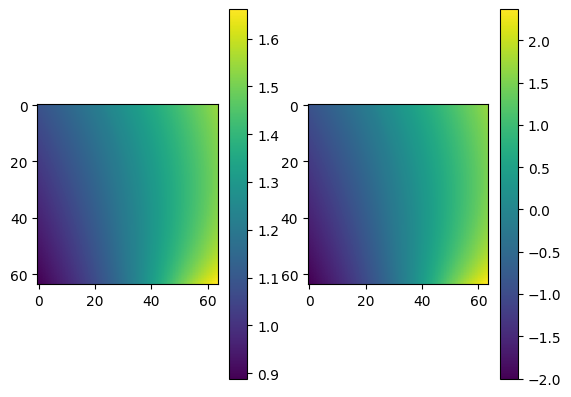

0.093406096


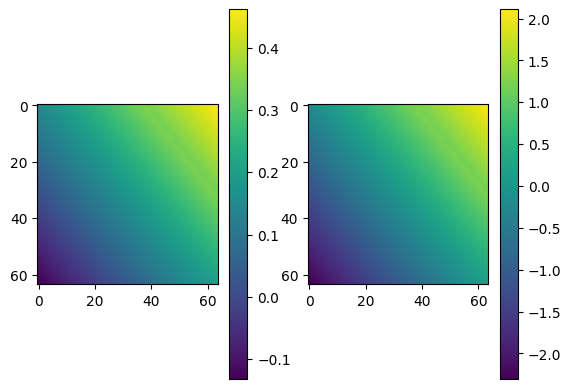

0.09256067


KeyboardInterrupt: 

In [15]:
# Veranschaulichung der Curiousitybewertung

prps = preprocess(np.asarray(replaybuffer))

for i in np.argsort(-cs)[:]:
    plt.subplot(121)
    plt.imshow(replaybuffer[i].astype('float32'))
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(prps[i].astype('float32'))
    plt.colorbar()
    plt.show()
    print(cs[i])

In [32]:
nrec = 24

algorithm = mandelbrot_cuda
algorithm = mandelbrot

def recursion(xmin, xmax, ymin, ymax, n=0, f=4, key=''):
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    #nmax = 2000
    nmax = 8000
    xarr, yarr = meshgrid(xarr, yarr)

    if n >= nrec: return
    
    if not key in visited:
        mandel = algorithm(xarr, yarr, nmax)
        #mandel = mandel_byreference_cuda(xarr, yarr, nmax)
        mandel = np.log(mandel).astype('float16')


        visited[key] = len(gallery_hr)
        gallery_hr.append(mandel)
        depths.append(n)
    else:
        mandel = gallery_hr[visited[key]]
       
    parts = mandel.reshape(f, 64, f, 64)
    parts = parts.transpose(0, 2, 1, 3).reshape((-1, 64, 64))
    c = _cost(parts)

    i = np.argsort(c)[(-1 if np.random.rand()>(.3) else -2)]  # sometimes take the second best to avoid repititions!
    i = np.argsort(c)[np.random.choice([-1, -2, -3, -4], p=(0.4, 0.3, 0.2, 0.1))]
    ##i = np.random.randint(f**2)

    w = xmax-xmin
    xmin = xmin + w/f * (i//f)
    xmax = xmin+w/f

    h = ymax-ymin
    ymin = ymin + h/f * (i%f)
    ymax = ymin+h/f

    key += str(i)+';'
    if not key in visited:
        gallery.append(parts[i])
        rects.append((xmin, xmax, ymin, ymax))
    
    ##del mandel, parts
    recursion(xmin, xmax, ymin, ymax, n+1, f, key)
    
    
n0 = 64
def render_mandel(rect, nmax=2000, n=n0, centered=True):
    xmin, xmax, ymin, ymax = rect
    xarr = np.linspace(xmin, xmax, n)
    yarr = np.linspace(ymin, ymax, n)
    if centered:
        xarr = np.linspace(xmin, xmax, n, endpoint=False) + (xmax-xmin)/n
        yarr = np.linspace(ymin, ymax, n, endpoint=False) + (ymax-ymin)/n
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = algorithm(xarr, yarr, nmax)
    mandel = np.log(mandel)
    mandel[np.isnan(mandel)] = 0
    return mandel
    
    
import heapq
import seaborn as sns

def init_leaf(xmin, xmax, ymin, ymax):
    global leafs_img, leafs_rect, leafs_pausetil
    mandel = render_mandel((xmin, xmax, ymin, ymax), 50)
    leafs_img = mandel[None]
    leafs_rect = [(xmin, xmax, ymin, ymax)]
    leafs_pausetil = [0]
    
ncalls=0
def sdfds(f=2):
    # für leaf bilder im array die costs auswerten
    global leafs_img, leafs_rect, leafs_pausetil, ncalls
    ncalls += 1
    
    c = cost(leafs_img)
    ##c += np.log2(np.array([ xmax-xmin for xmin, xmax, _, _, in leafs_rect ])) \
    ##        * np.random.choice((1/20, 1/40, 0))
    c += - np.max(np.array(leafs_pausetil)-ncalls, 0)
    
    # finde best 10 werte und tue sie in max-queue
    largest = heapq.nlargest(10, range(len(leafs_img)), c.__getitem__)
    
    '''
    ## TEST
    c /= c.max()
    if ncalls%10==0: sns.distplot(c); plt.show()
    p = np.exp(c*6)
    largest = np.random.choice(range(len(c)), size=10, p=p/sum(p))
    ## END TEST'''
    
    # iteration um bilder zu finden
    for i in largest:
        
        # bild in hd rendern(?)
        mandel = render_mandel(leafs_rect[i], n=f*n0)
        rects.append(leafs_rect[i])
        gallery.append(leafs_img[i].astype('float16'))
        gallery_hr.append(mandel.astype('float16'))
        
        
        # bild teilen und werte berechnen, dann in den array, dann in die queue
        new = mandel.reshape((f, n0, f, n0)).transpose((0, 2, 1, 3)).reshape((-1, n0, n0)).astype('float16')
        leafs_img = np.concatenate((leafs_img, new))
        
        xmin, xmax, ymin, ymax = leafs_rect[i]
        w, h = (xmax-xmin)/f, (ymax-ymin)/f
        
        leafs_rect += [(xmin+j*w, xmin+(j+1)*w, ymin+k*w, ymin+(k+1)*w) for j in range(f) for k in range(f)]
        leafs_pausetil += f**2 * [ncalls + 50]
        
    # aufräumen
    for i in sorted(largest, reverse=True):
        leafs_img[i:-1] = leafs_img[i+1:]
        leafs_img = leafs_img[:-1]
        leafs_rect.pop(i)
        leafs_pausetil.pop(i)
        

In [33]:
init_leaf(-1.5, .5, 0, 2)

C:\Users\Ma Ha\AppData\Local\Temp\ipykernel_16936\3582678848.py:63: RuntimeWarning: invalid value encountered in log
  mandel = np.log(mandel)


In [34]:
bnum = 64
gallery = []
gallery_hr = []
depths = []
costs = []
rects = []
visited = dict()

In [49]:
import pickle

last = len(gallery)
last_hr = len(gallery_hr)
for k in range(99999999999):
    for _ in range(10):
        #sdfds()
        print('here')
        recursion(-1.5, .5, -1, 1, f=4)
    #print(len(gallery), len(leafs_img), len(leafs_rect))
    print(len(gallery), len(gallery_hr))

    #for im in gallery_hr[last::5]:
    for k in range(last_hr, len(gallery_hr), 1):
        im = gallery_hr[k]
        plt.imshow(im.T[::-1].astype('float64'))
        ##plt.title(depths[k])
        plt.show()
    last_hr = len(gallery_hr)
        
    #new = np.stack(gallery[last:])
    #replaybuffer = np.concatenate((new, replaybuffer))
    new = gallery[last:]
    replaybuffer = gallery[last:]+replaybuffer
    print('rb:', len(replaybuffer))
    last = len(gallery)
    
    for _ in range(100):
        p1 = np.exp(-1/500*np.arange(len(replaybuffer)))
        p2 = np.exp(-1/200000*np.arange(len(replaybuffer)))
        indf = lambda: np.concatenate((np.random.choice(range(len(new)), 16),
                                      np.random.choice(range(len(replaybuffer)), bnum//2, p=p1/sum(p1)),
                                      np.random.choice(range(len(replaybuffer)), bnum//2-16, p=p2/sum(p2)),))
        l = trainstep(indf)
        print('Loss = ', l)
    
    #if k%50 == 0:
    #    with open('F:/$Daten/mandelbrot_gallery_both.pkl', 'wb') as f:
    #        pickle.dump((rects, gallery, gallery_hr), f)

here


KeyboardInterrupt: 

In [37]:
with open('F:/$Daten/mandelbrot_gallery_both.pkl', 'wb') as f:
    pickle.dump((rects, gallery, gallery_hr), f)

In [ ]:

while True:
    recursion(-1.5, .5, -1, 1, f=10)   ###### test mit höhem f, findet er feinere strukturen wie spiralen???
    
    new = np.asarray(gallery[-nrec:])
    new_hr = np.asarray(gallery_hr[-nrec:])
    for im in new_hr:
        plt.imshow(im.T[::-1])
        plt.show()
    replaybuffer = np.concatenate((new, replaybuffer))
    print('here')
    for _ in range(50):
        p1 = np.exp(-1/2000*np.arange(len(replaybuffer)))
        p2 = np.exp(-1/200000*np.arange(len(replaybuffer)))
        indf = lambda: np.concatenate((np.random.choice(range(len(new)), 16),  # at least one of the new
                                      np.random.choice(range(len(replaybuffer)), bnum//2, p=p1/sum(p1)),
                                      np.random.choice(range(len(replaybuffer)), bnum//2-16, p=p2/sum(p2)),))
        l = trainstep(indf)
        print('Loss = ', l)

In [ ]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
with open('F:\\$Daten\\mandelbrot_gallery_both.pkl', 'rb') as f:
    rects, gallery, gallery_hr = pkl.load(f)
    

In [ ]:
for r in rects[64:66]:
    f=4
    xmin, xmax, ymin, ymax = r
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    nmax = 2000
    #nmax = 4000 ###
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = mandelbrot_cuda(xarr, yarr, nmax)
    mandel = np.log(mandel)
    plt.imshow(mandel.T[::-1])
    plt.show()

In [ ]:
for r in rects[64:66]:
    f=4
    xmin, xmax, ymin, ymax = r
    xarr = np.linspace(xmin, xmax, 64*f)
    yarr = np.linspace(ymin, ymax, 64*f)
    nmax = 2000 
    nmax = 8000
    xarr, yarr = meshgrid(xarr, yarr)

    mandel = mandelbrot_cuda(xarr, yarr, nmax)
    mandel = np.log(mandel)
    plt.imshow(mandel.T[::-1])
    plt.show()

In [44]:

def upscale_image_nearest(image, factor):
    """
    Skaliert ein Bild um den Faktor `factor` mit nearest-neighbor Interpolation hoch.

    :param image: numpy-Array mit Form (Höhe, Breite, Kanäle) oder (Höhe, Breite) für Graustufenbilder
    :param factor: Skalierungsfaktor (muss > 1 sein)
    :return: Hochskaliertes Bild als numpy-Array
    """
    if factor <= 0:
        raise ValueError("Der Skalierungsfaktor muss größer als 1 sein.")

    original_height, original_width = image.shape[:2]
    new_height, new_width = int(original_height * factor), int(original_width * factor)

    # Erstelle ein leeres Array für das hochskalierte Bild
    if image.ndim == 3:  # Farbbild
        scaled_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)
    else:  # Graustufenbild
        scaled_image = np.zeros((new_height, new_width), dtype=image.dtype)

    # Iteriere über die neuen Pixel und kopiere den nächsten Nachbar
    for i in range(new_height):
        for j in range(new_width):
            original_i = int(i / factor)
            original_j = int(j / factor)
            scaled_image[i, j] = image[original_i, original_j]

    return scaled_image

In [48]:
for k, img in enumerate(gallery_hr):
    plt.imsave('F:\\$Daten\\vidcaptures\\mandelbrot_generated\\img%05d.png' % k, img)